<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

<div class="alert alert-warning">

### i) Perform any cleaning, feature engineering, and EDA you deem necessary. ###

</div>

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.shape

(1460, 81)

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# with signficant number of null values. 
# Given that MiscVal is directly related to MiscFeature and MiscFeature is going to be dropped, MiscVal will be dropped as well. 

house.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'], axis = 1, inplace = True)

In [7]:
house.shape

(1460, 75)

<div class="alert alert-warning">

### ii) Be sure to remove any houses that are not residential from the dataset. ###

</div>

In [8]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [9]:
# remove non-residential houses

house = house[house['MSZoning'].isin(['FV', 'RH', 'RL', 'RP', 'RM'])]

In [10]:
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

<div class="alert alert-warning">

### iii) Identify **fixed** features that can predict price. ###

</div>

In [11]:
# Drop Id (Redundant feature) from dataset

house.drop(columns = 'Id', axis = 1, inplace = True)

In [12]:
# Defining list of non_fixed_attributes

non_fixed_attributes = ['OverallQual', 'OverallCond','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
'MasVnrType', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF','Heating', 'HeatingQC','CentralAir',\
'Electrical', 'LowQualFinSF', 'GrLivArea', 'KitchenQual', 'TotRmsAbvGrd','Functional','GarageFinish','GarageQual', 'GarageCond',\
'PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', \
'PoolArea']

In [13]:
# drop non-fixed (i.e. renovat-able) features

house_ffeatures = house.drop(columns = non_fixed_attributes, axis = 1)

In [14]:
house_ffeatures.shape

(1450, 38)

In [15]:
house_ffeatures.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [16]:
# Split the columns up into categorical and non-categorical variables for the purposes of performing EDA

ffeatures_cat = ['MSSubClass','MSZoning','Street','LotShape','LandContour', 'Utilities', 'LotConfig', \
                 'LandSlope','Neighborhood','Condition1', 'Condition2','BldgType','HouseStyle',\
                 'Foundation','BsmtQual','GarageType','SaleType','SaleCondition']

ffeatures_noncat = ['LotFrontage','LotArea', 'TotalBsmtSF','1stFlrSF','2ndFlrSF', 'YearBuilt',\
                     'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath','BsmtHalfBath','FullBath',\
                     'HalfBath', 'BedroomAbvGr','KitchenAbvGr','Fireplaces', 'GarageYrBlt','GarageCars','GarageArea',\
                     'MoSold', 'YrSold']

**Impute missing values in fixed features**

In [17]:
# Check null values for categorical variables

house_ffeatures[ffeatures_cat].isnull().sum()

MSSubClass        0
MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
Foundation        0
BsmtQual         37
GarageType       79
SaleType          0
SaleCondition     0
dtype: int64

In [18]:
# Given that null value for BsmtQual means no basement and null value for GarageType means no garage, we can represent the
# null values in these columns as a separate category

house_ffeatures['BsmtQual'].fillna('No Bsmnt', inplace = True)
house_ffeatures['GarageType'].fillna('No Garage', inplace = True)

In [19]:
# Check null values for non-categorical variables

house_ffeatures[ffeatures_noncat].isnull().sum()

LotFrontage     259
LotArea           0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
YearBuilt         0
YearRemodAdd      0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
Fireplaces        0
GarageYrBlt      79
GarageCars        0
GarageArea        0
MoSold            0
YrSold            0
dtype: int64

In [20]:
# Replace null values in LotFrontage and GarageYrBlt with median. 

house_ffeatures['LotFrontage'].fillna(house_ffeatures['LotFrontage'].median(), inplace = True)
house_ffeatures['GarageYrBlt'].fillna(house_ffeatures['GarageYrBlt'].median(), inplace = True)

In [21]:
house_ffeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 38 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
Foundation       1450 non-null object
BsmtQual         1450 non-null object
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
BsmtFullBath     1450 non-null int64
BsmtHalfBath     1450 non-

**Perform visual EDA on both categorical and non-categorical variables against price**

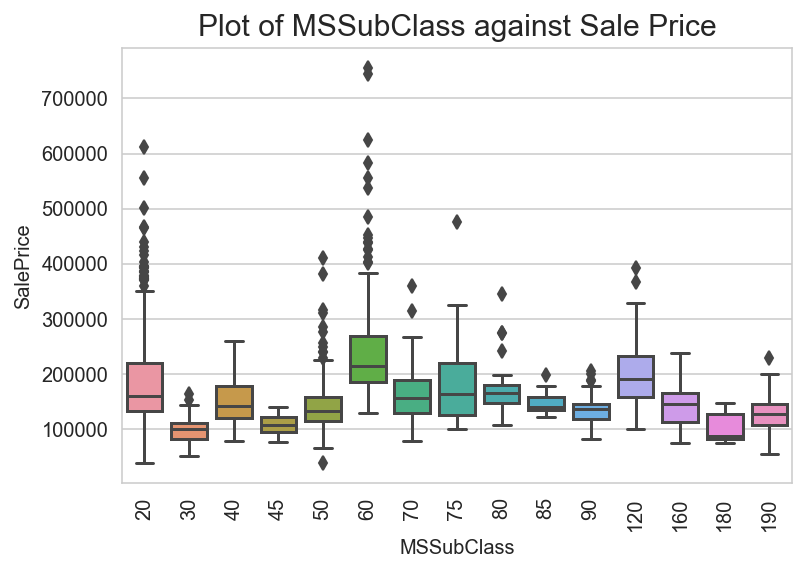

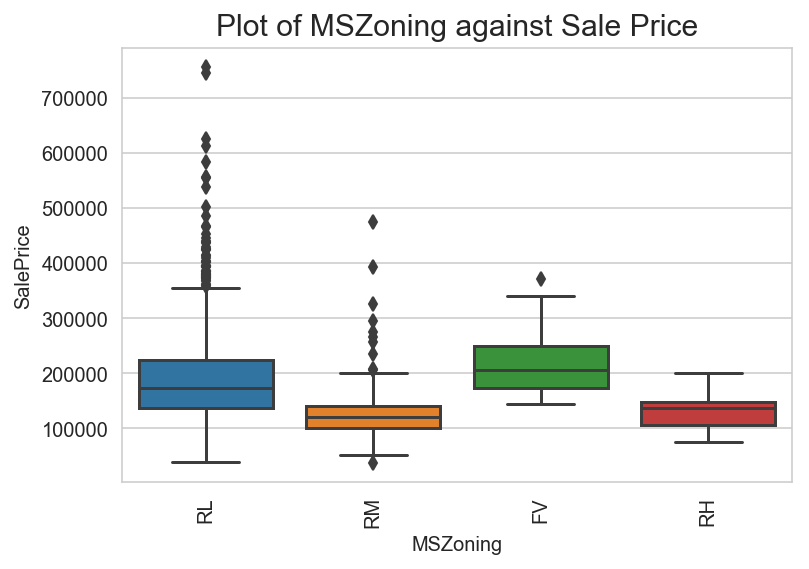

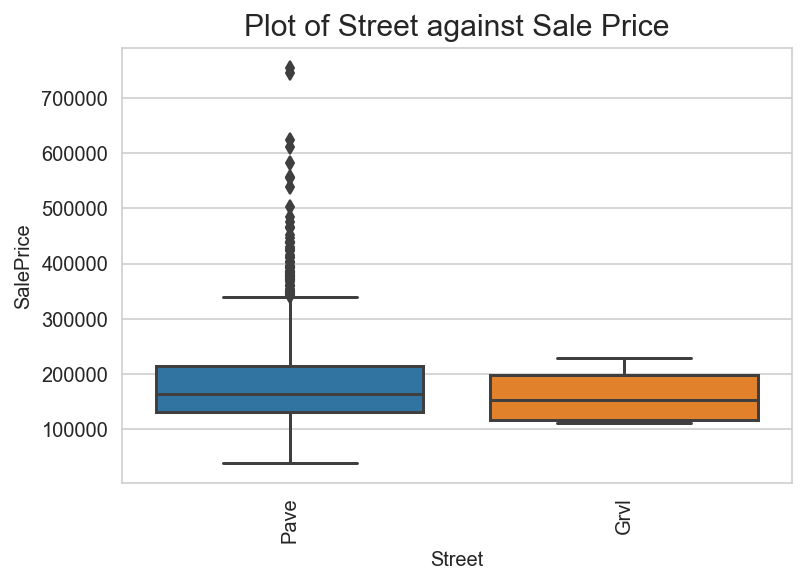

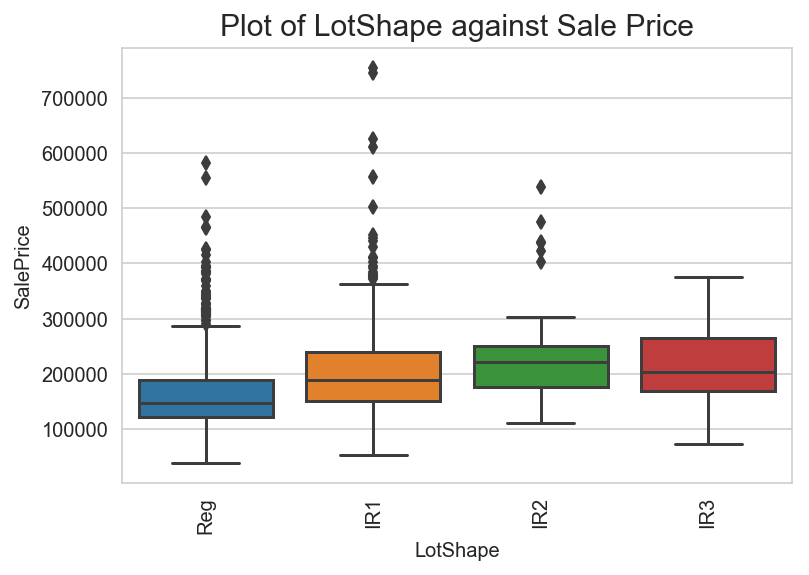

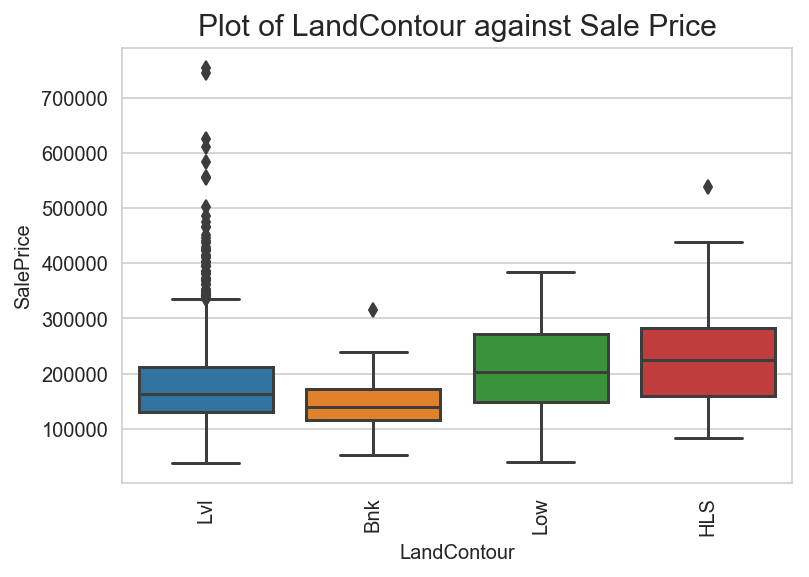

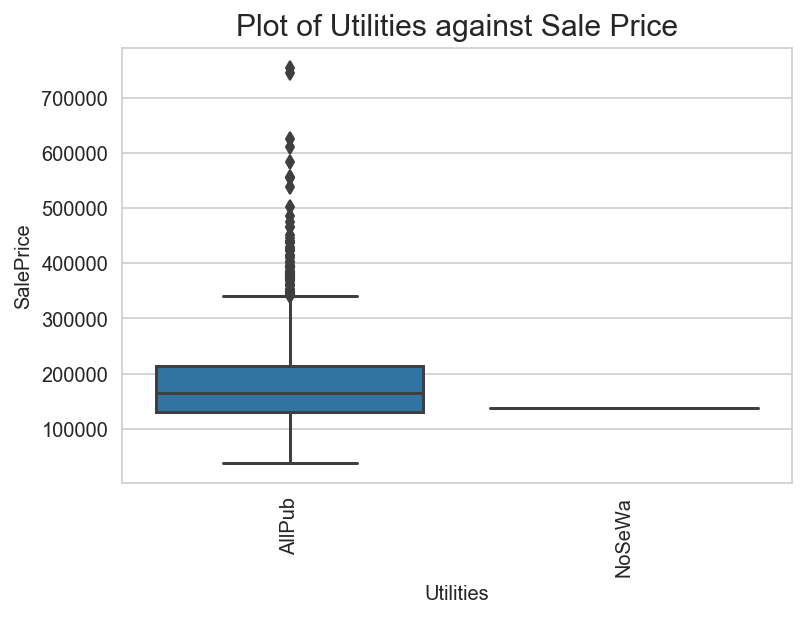

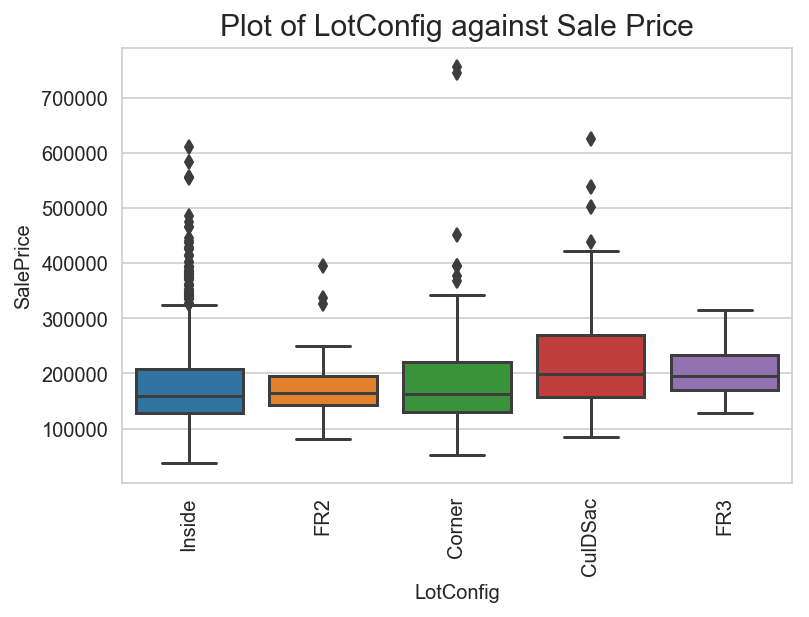

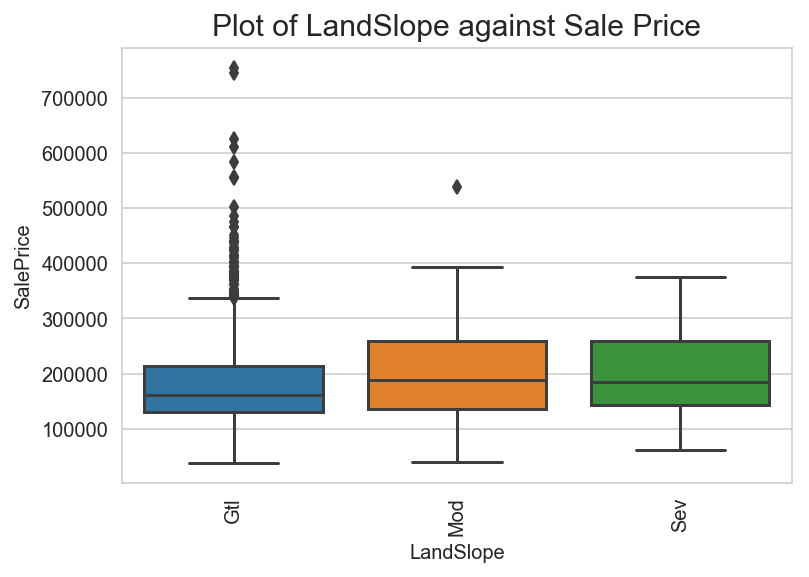

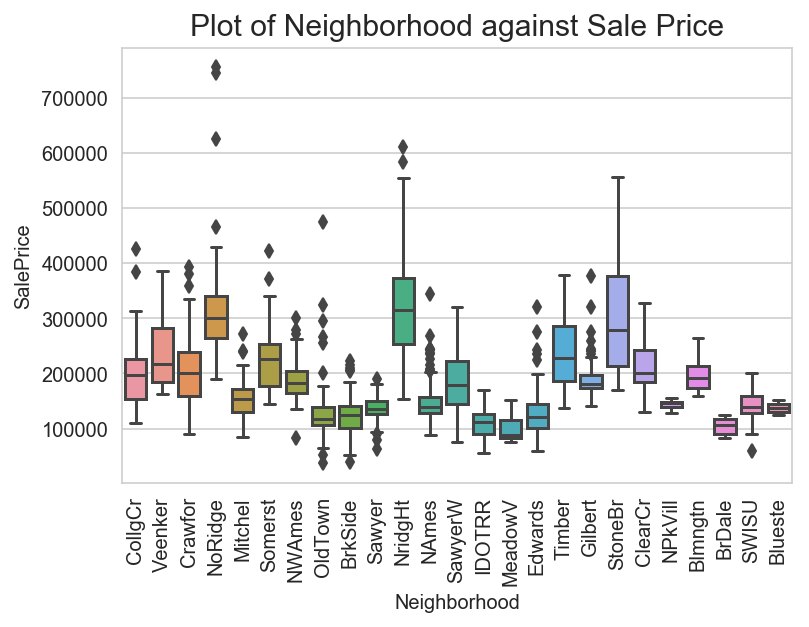

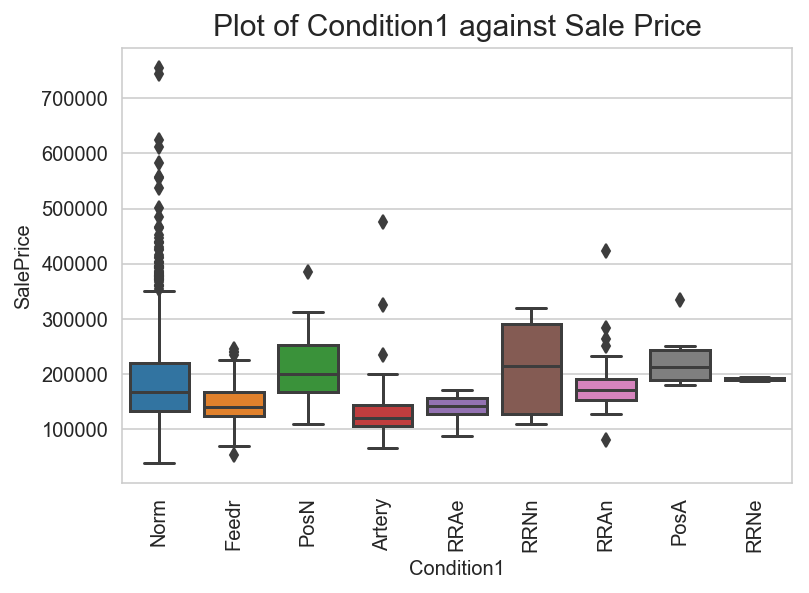

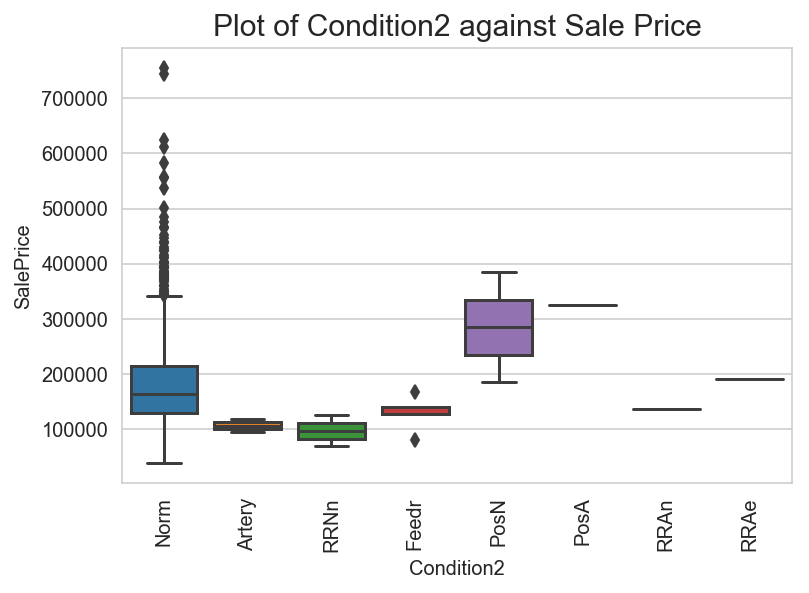

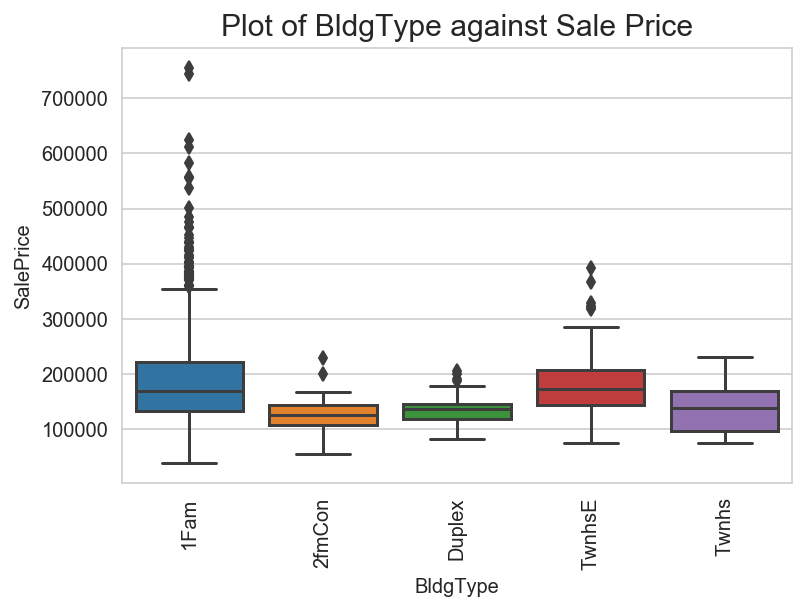

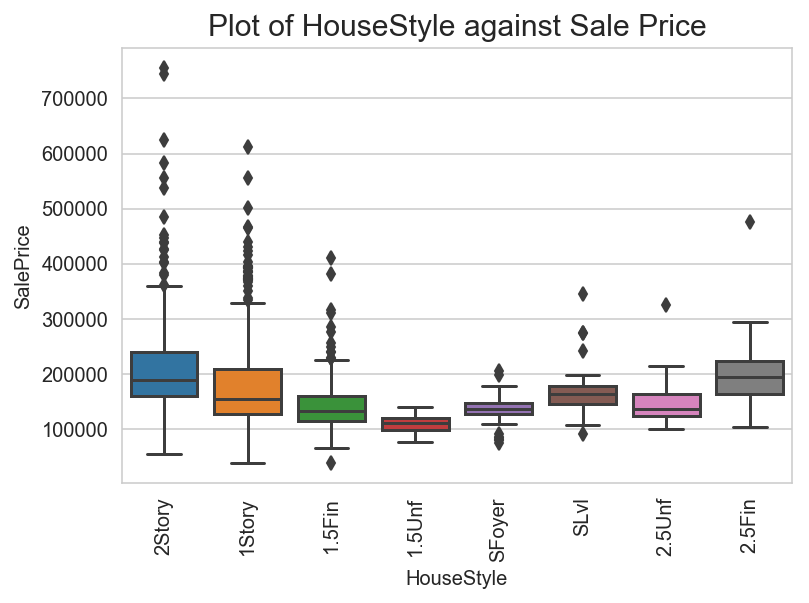

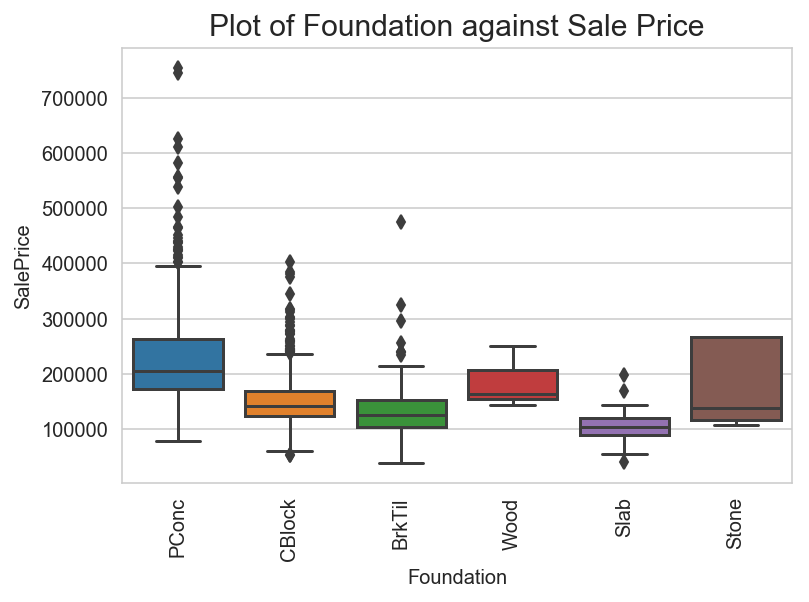

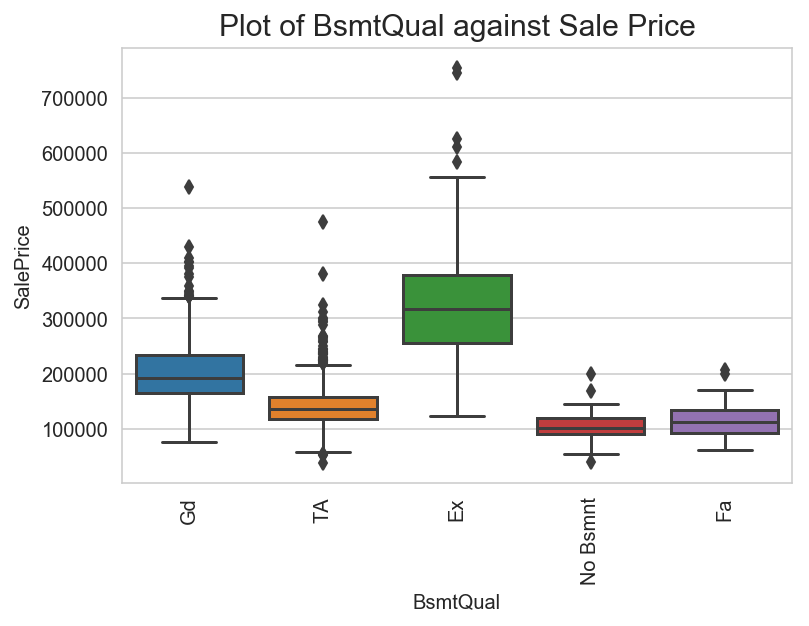

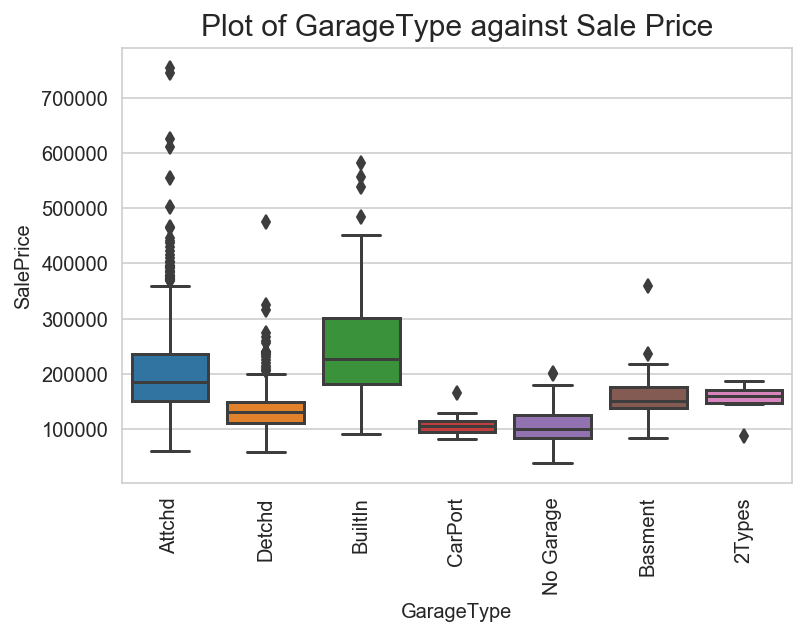

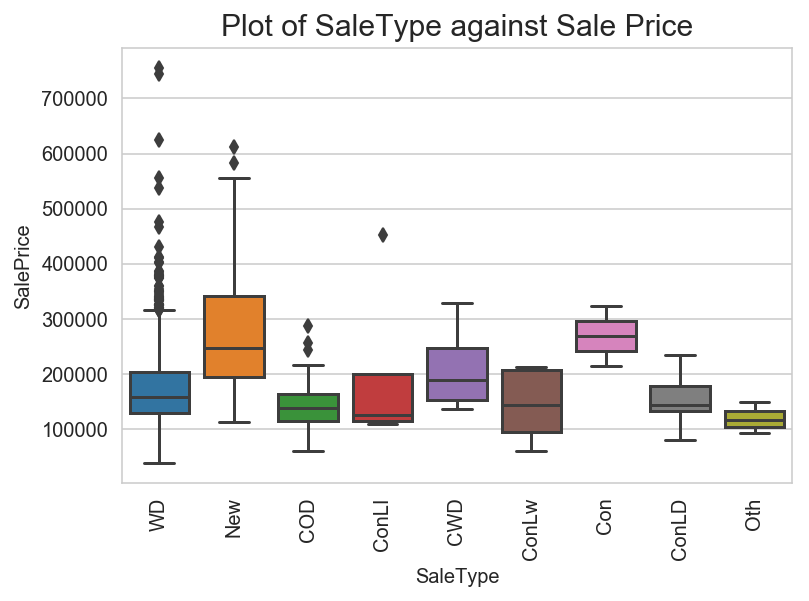

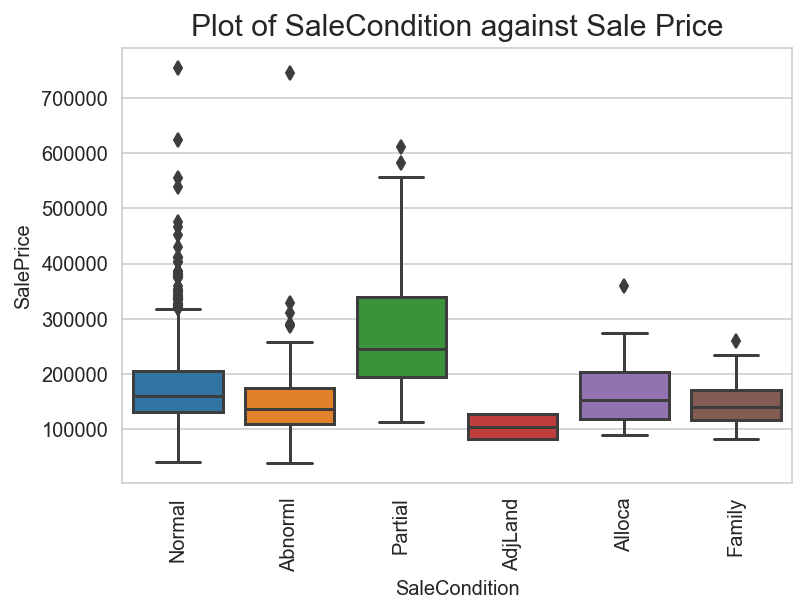

In [22]:
# Visual EDA on categorical variables against price using boxplot

for col in ffeatures_cat:
    plt.figure()
    plt.xticks(rotation = 90)
    plt.title('Plot of {} against Sale Price'.format(col), fontsize = 15)
    sns.boxplot(house_ffeatures[col], house_ffeatures['SalePrice']);

There appears to be a couple of outliers across all features with Sale price >$700k.

In [23]:
house_ffeatures[house_ffeatures['SalePrice'] > 700000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,60,RL,104.0,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,2,Attchd,1994.0,3,832,1,2007,WD,Normal,755000
1182,60,RL,160.0,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,2,Attchd,1996.0,3,813,7,2007,WD,Abnorml,745000


Let us remove the above two outliers with Saleprice > $700k to avoid skewing the dataset. 

In [24]:
# Removing 2 outliers from fixed features dataset

house_ffeatures = house_ffeatures[~(house_ffeatures['SalePrice'] > 700000)]

In [25]:
house_ffeatures.shape

(1448, 38)

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


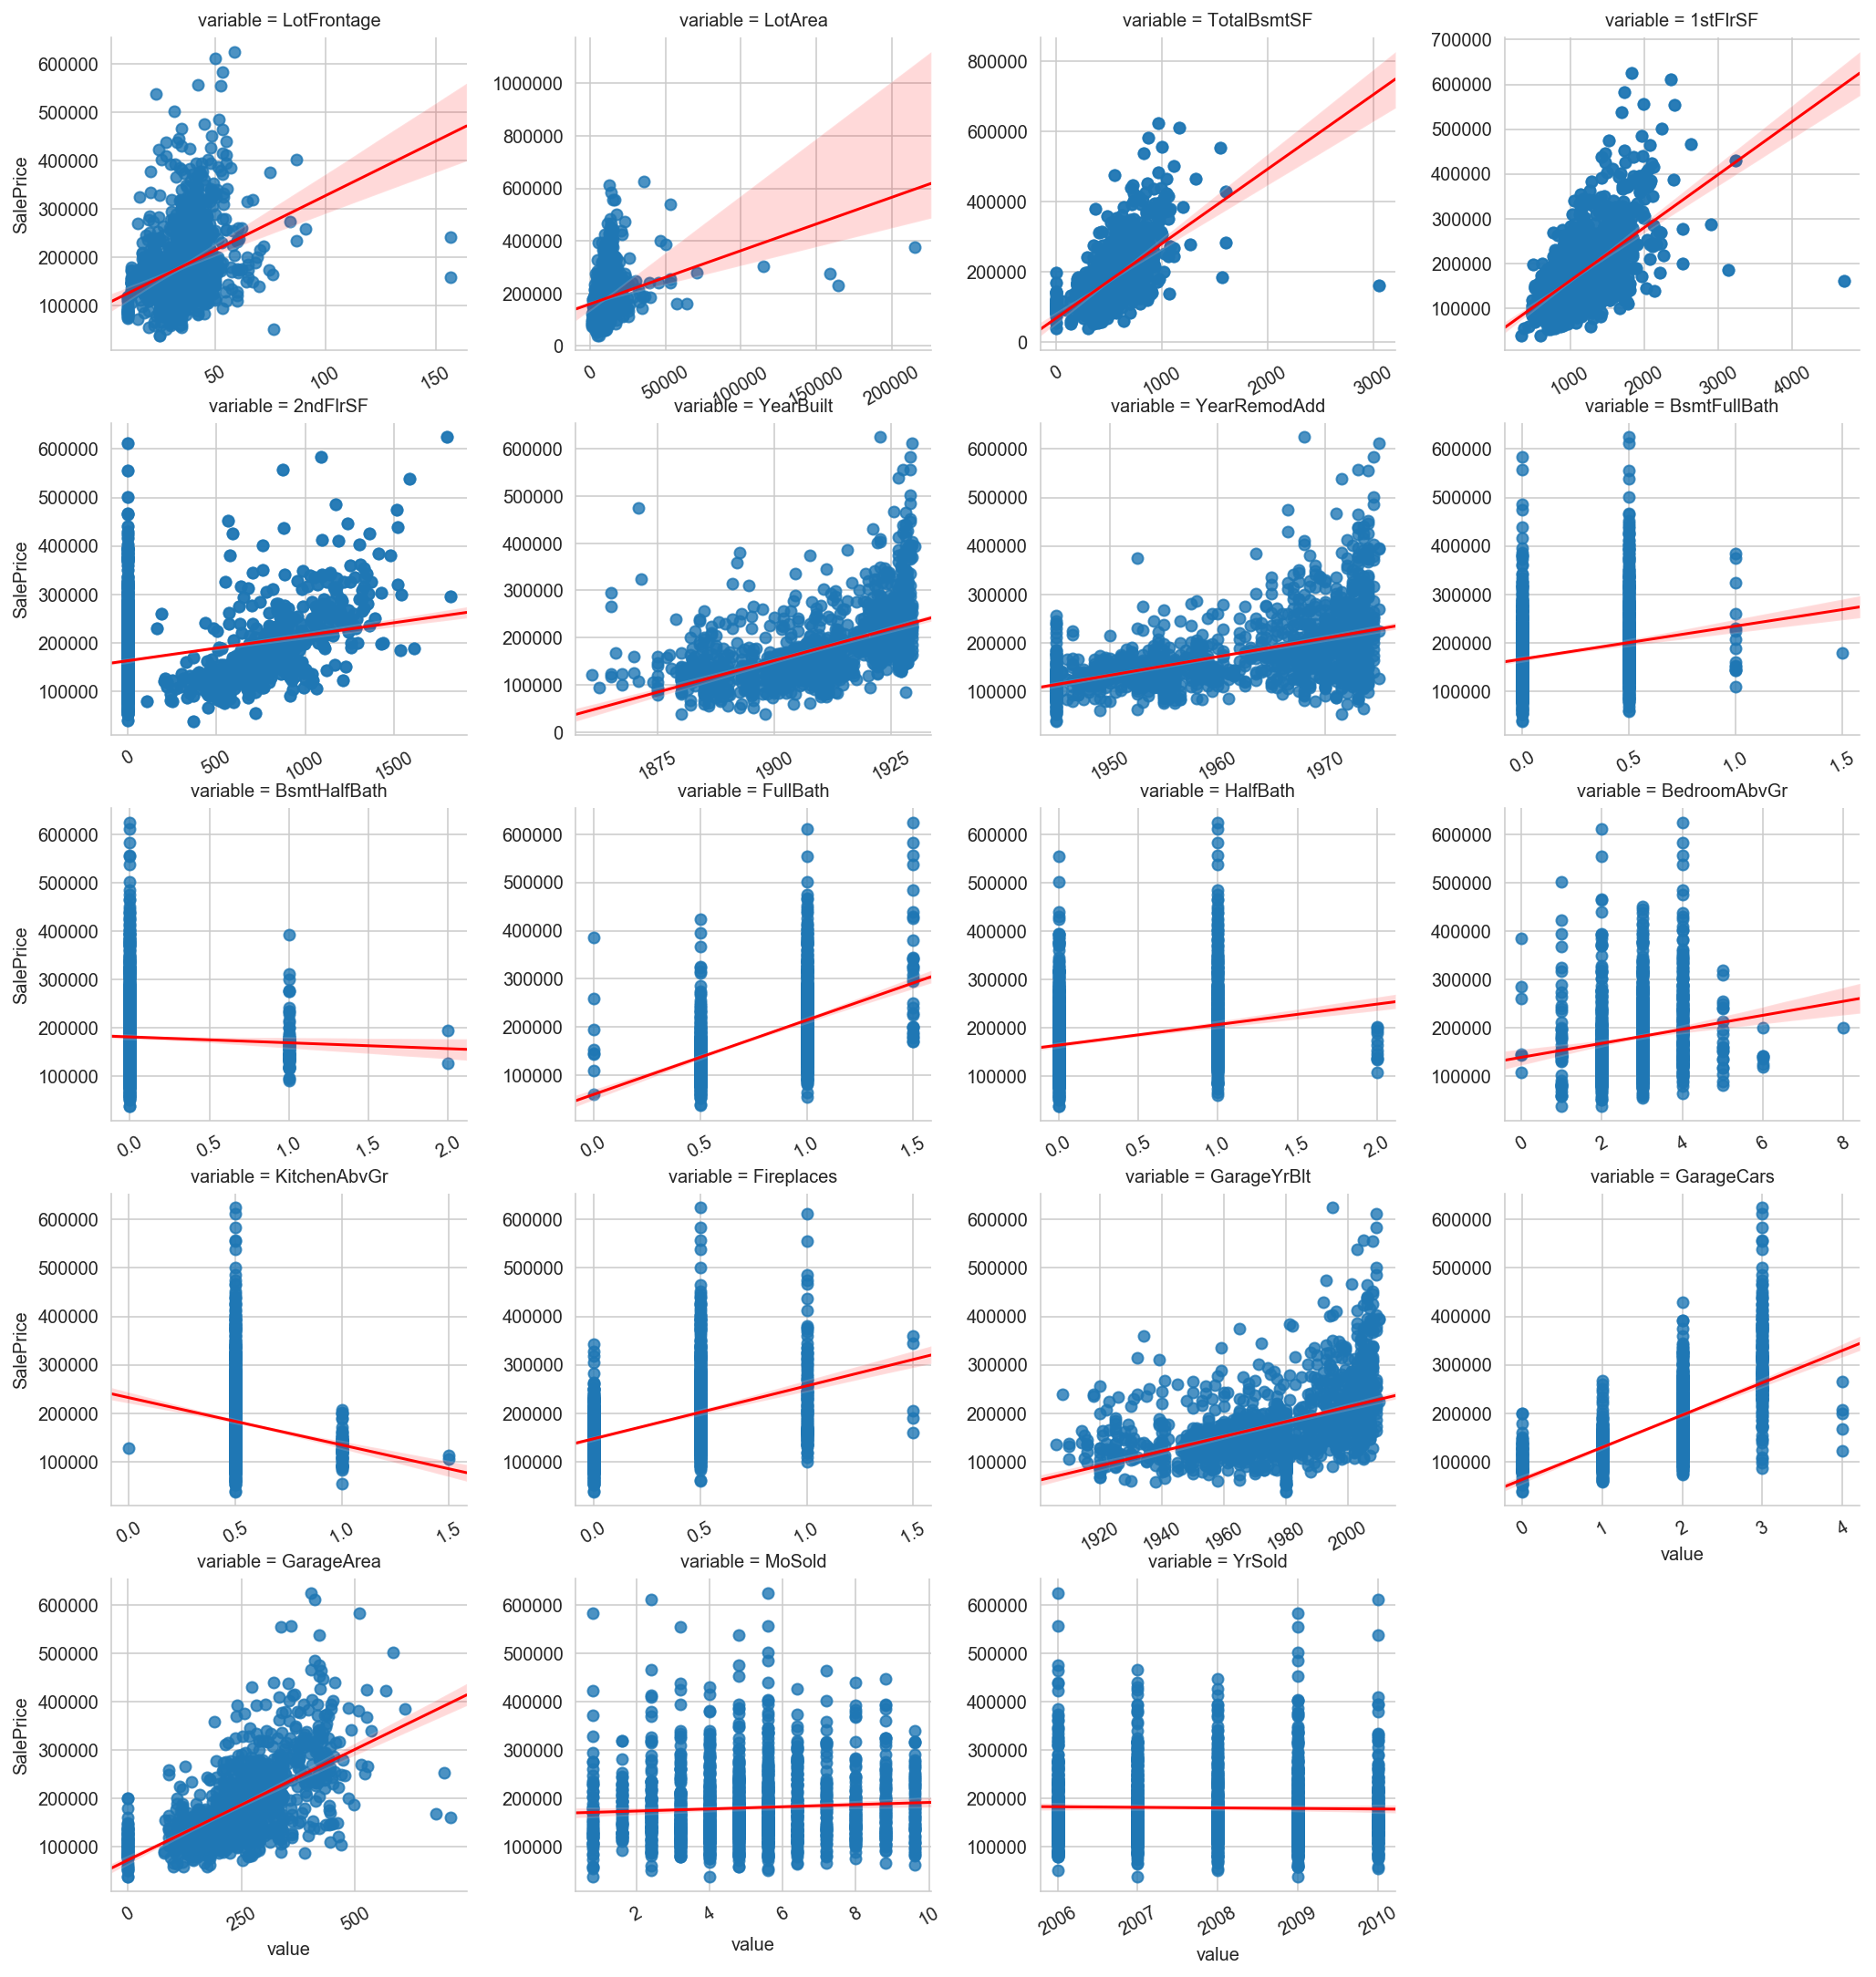

In [26]:
# Visual EDA on non-categorical variables against price using regplot

noncat_plot = pd.melt(house_ffeatures[ffeatures_noncat].join(house_ffeatures['SalePrice']), id_vars = 'SalePrice')

g = sns.FacetGrid(noncat_plot, col= 'variable', col_wrap= 4, sharex=False, sharey=False, aspect = 1.2)
g = g.map(sns.regplot, 'value','SalePrice', line_kws={'color':'red','linewidth':1.5});
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels

There appears to be outliers in 'Area' related features like LotFrontage, LotArea, TotalBsmtSF, 1stFlrSF. We will await evaluation of feature importance in the next section before evaluating whether outliers in these features should be eliminated. 

It might be worth taking the log of Sale price as well to improve performance if space related features like LotArea, TotalBsmtSF, 1stFlrSF and 2ndFlrSF prove to be important. 

In [27]:
# # Removing renovatable 

# fixed_attributes = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
                    
#                     'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
#                     'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
#                     'YearRemodAdd','MasVnrArea','BsmtQual', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
#                     'BsmtFullBath', 'BsmtHalfBath',
#                     'Fireplaces', 'GarageYrBlt','GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 
#                     'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', 'PoolArea', 'MiscFeature', 
#                     'MiscVal','MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']]

# non_fixed_attributes = 'OverallQual', 'OverallCond','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
# 'MasVnrType', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
# 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF','Heating', 'HeatingQC','CentralAir',\
# 'Electrical', 'KitchenQual','Functional','GarageFinish','GarageQual', 'GarageCond',\
# 'PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', \
# 'PoolArea', 'MiscVal','MoSold', 'YrSold','SaleType','SaleCondition']

In [28]:
house_ffeatures.describe()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,...,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,SalePrice
count,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,...,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000
mean,56.899171,69.957873,10512.705801,1971.560773,1985.035221,1057.529696,1163.029006,345.155387,0.427486,0.056630,...,0.383978,2.868785,1.046271,0.614641,1978.679558,1.768646,472.795580,6.315608,2007.813536,180869.935083
std,42.294074,21.891964,10014.016443,30.030791,20.562834,436.585252,384.050216,433.203475,0.519413,0.237116,...,0.503278,0.814124,0.219788,0.643381,23.923821,0.744246,212.437347,2.696432,1.326893,76357.489054
min,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,334.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1906.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,20.000000,60.000000,7538.750000,1954.000000,1967.000000,796.000000,882.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,1.000000,0.000000,1962.000000,1.000000,336.000000,5.000000,2007.000000,130000.000000
50%,50.000000,70.000000,9491.000000,1973.000000,1994.000000,992.000000,1088.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,1.000000,1.000000,1980.000000,2.000000,479.500000,6.000000,2008.000000,163700.000000
75%,70.000000,79.000000,11601.500000,2001.000000,2004.000000,1299.250000,1392.000000,728.000000,1.000000,0.000000,...,1.000000,3.000000,1.000000,1.000000,2001.000000,2.000000,576.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,2010.000000,2010.000000,6110.000000,4692.000000,1818.000000,3.000000,2.000000,...,2.000000,8.000000,3.000000,3.000000,2010.000000,4.000000,1418.000000,12.000000,2010.000000,625000.000000


**Create dummies for categorical variables**

In [29]:
house_ffeatures = pd.get_dummies(data = house_ffeatures, columns = ffeatures_cat, drop_first = True)

In [30]:
house_ffeatures.shape

(1448, 129)

In [31]:
pd.set_option('display.max_seq_items', None)

house_ffeatures.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'MoSold', 'YrSold', 'SalePrice',
       'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50',
       'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80',
       'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160',
       'MSSubClass_180', 'MSSubClass_190', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Pave', 'LotShape_IR2', 'LotShape_IR3',
       'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr',

<div class="alert alert-warning">

### iv) Train a model on pre-2010 data and evaluate its performance on the 2010 houses. ###

</div>

We will train and test on all features using the techniques in the following order:
- i)   Linear Regression (as a baseline)
- ii)  Ridge Regression
- iii) Lasso Regression 
- iv)  ElasticNet Regression. 

Feature selection will be done in the next section.

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [33]:
# Select pre-2010 data as training set

train_set = house_ffeatures[house_ffeatures['YrSold'] < 2010]
X_train = train_set.drop(['SalePrice'], axis = 1)
y_train = train_set['SalePrice'].values

test_set = house_ffeatures[house_ffeatures['YrSold'] >= 2010]
X_test = test_set.drop(['SalePrice'], axis = 1)
y_test = test_set['SalePrice'].values

In [34]:
# Standardise predictor variables

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [35]:
Xs_train.shape

(1276, 128)

**Model 1: Using Linear Regression**

In [36]:
# Instantiate model
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

In [37]:
# Cross val R2 score for training data

scores = cross_val_score(lr, X_train, y_train, cv = 10)
print(scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(scores), np.std(scores)))

[0.88362403 0.80047142 0.85824375 0.74564258 0.85825848 0.71183178
 0.86802529 0.79887046 0.44443711 0.79772376]
The mean cross validated R2 score for the training data is 0.7767, and the standard deviation is 0.1225


In [38]:
# Calculate R2 and mean squared error on testing data

y_pred = lr_model.predict(X_test)

print('R2 score when tested with test data is {}'.format(lr_model.score(X_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

R2 score when tested with test data is 0.8591485190673996
Root mean squared error score is 29924.055180141047


In [39]:
# Assess variable significance using Linear Regression

lr_coefs = pd.DataFrame({'variable': X_train.columns,
                         'abs_coef': np.abs(lr_model.coef_),
                         'coef': lr_model.coef_,})

lr_coefs.sort_values('abs_coef', inplace = True, ascending = False)

lr_coefs.head(10)

,variable,abs_coef,coef
85,Condition2_PosN,138005.864384,-138005.864384
84,Condition2_PosA,93384.832054,93384.832054
116,SaleType_Con,73271.067660,73271.067660
71,Neighborhood_StoneBr,56645.699319,56645.699319
114,GarageType_No Garage,49296.022728,49296.022728
65,Neighborhood_NridgHt,46285.988545,46285.988545
64,Neighborhood_NoRidge,44716.388959,44716.388959
110,GarageType_Basment,44135.402568,44135.402568
111,GarageType_BuiltIn,40492.903603,40492.903603
106,BsmtQual_Gd,40045.278102,-40045.278102


In [40]:
# Cross check against sm.OLS
import statsmodels.api as sm


Xl = sm.add_constant(X_train)
model = sm.OLS(y_train,Xl).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     58.05
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:13:49   Log-Likelihood:                -14870.
No. Observations:                1276   AIC:                         3.000e+04
Df Residuals:                    1148   BIC:                         3.065e+04
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.493e+05   1.58e+06      0.411      0.681   -2.45e+06    3.75e+06
LotFrontage            -164.8766     54.609     -3.019      0.003    -272.022     -57.731
LotArea                   0.6279      0.127      4.959      0.000       0.379       0.876
YearBuilt               220.4229    102.170      2.157      0.031      19.961     420.885
YearRemodAdd            301.9356     61.102      4.942      0.000     182.052     421.819
TotalBsmtSF              10.7674      5.353      2.011      0.045       0.264      21.271
1stFlrSF                 51.6291      6.185      8.347      0.000      39.493      63.765
2ndFlrSF                 59.6910      6.875      8.682      0.000      46.202      73.181
BsmtFullBath           1.227e+04   1973.548      6.216      0.000    8395.135    1.61e+04
BsmtHalfBath           5306.9903   3696.953      1.436      0.151   -1946.552    1.26e+04
FullBath               7854.5996   2901.344      2.707      0.007    2162.068    1.35e+04
HalfBath               6414.8869   2766.813      2.319      0.021     986.310    1.18e+04
BedroomAbvGr          -4265.8132   1627.355     -2.621      0.009   -7458.737   -1072.889
KitchenAbvGr          -2.557e+04   7520.603     -3.400      0.001   -4.03e+04   -1.08e+04
Fireplaces             7696.8438   1748.887      4.401      0.000    4265.470    1.11e+04
GarageYrBlt             -90.1706     76.894     -1.173      0.241    -241.040      60.698
GarageCars             1.565e+04   2881.160      5.430      0.000    9992.305    2.13e+04
GarageArea                0.6849     10.267      0.067      0.947     -19.459      20.829
MoSold                 -120.6299    323.210     -0.373      0.709    -754.779     513.519
YrSold                 -736.5869    784.417     -0.939      0.348   -2275.639     802.465
MSSubClass_30         -8386.8110   6250.233     -1.342      0.180   -2.06e+04    3876.351
MSSubClass_40          -560.9345   1.84e+04     -0.030      0.976   -3.68e+04    3.56e+04
MSSubClass_45         -1.387e+04   2.71e+04     -0.512      0.609    -6.7e+04    3.93e+04
MSSubClass_50         -2919.8346   1.18e+04     -0.247      0.805   -2.61e+04    2.03e+04
MSSubClass_60         -1.416e+04   1.01e+04     -1.404      0.161   -3.39e+04    5628.108
MSSubClass_70         -5581.9995   1.07e+04     -0.524      0.601   -2.65e+04    1.53e+04
MSSubClass_75          1717.1920   1.96e+04      0.088      0.930   -3.67e+04    4.01e+04
MSSubClass_80         -6113.4176   1.62e+04     -0.376      0.707    -3.8e+04    2.58e+04
MSSubClass_85         -3284.9398   1.44e+04     -0.227      0.820   -3.16e+04    2.51e+04
MSSubClass_90         -2039.6720   4641.490     -0.439      0.660   -1.11e+04    7067.083
MSSubClass_120        -1.847e+04   1.86e+04     -0.995      0.320   -5.49e+04    1.79e+04
MSSubClass_160         

The OLS scores will be used in the next section on feature selection to improve the scores

**Model 2: Using Ridge Regression**

In [41]:
# find optimal Ridge alpha and cross val R2 score using training data

ridge_alphas = np.logspace(0,5,200)

optimal_ridge = RidgeCV(alphas = ridge_alphas, cv = 10)
optimal_ridge.fit(Xs_train, y_train)


ridge = Ridge(alpha = optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv = 10)

print(ridge_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(ridge_scores), np.std(ridge_scores)))

[0.8917059  0.8068054  0.85487542 0.75510947 0.83827472 0.7830552
 0.86679476 0.81544417 0.49995159 0.81561883]
The mean cross validated R2 score for the training data is 0.7928, and the standard deviation is 0.1047


In [42]:
# Calculate R2 and mean squared error on testing data

ridge.fit(Xs_train, y_train)
y_pred = ridge.predict(Xs_test)

print('R2 score when tested with test data is {}'.format(ridge.score(Xs_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

R2 score when tested with test data is 0.8443418069024867
Root mean squared error score is 31457.61047898971


**Model 3: Using Lasso Regression**

In [43]:
# find optimal Lasso alpha and cross val R2 score using training data

optimal_lasso = LassoCV(n_alphas = 500, cv = 10)
optimal_lasso.fit(Xs_train, y_train)

lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv = 10)

print(lasso_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(lasso_scores), np.std(lasso_scores)))

[0.89359763 0.83248073 0.86439763 0.76784567 0.8509465  0.75540741
 0.8851888  0.81138633 0.42702144 0.82635535]
The mean cross validated R2 score for the training data is 0.7915, and the standard deviation is 0.1289


There appears to be an odd result (0.42702144) in one of the folds.

In [44]:
# Calculate R2 and mean squared error on testing data

lasso.fit(Xs_train, y_train)
y_pred = lasso.predict(Xs_test)

print('R2 score when tested with test data is {}'.format(lasso.score(Xs_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

R2 score when tested with test data is 0.8548797736736651
Root mean squared error score is 30374.12050673673


In [45]:
# Check percentage of variables zeroed out

print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))*100,'%')

Percent variables zeroed out: 43.75 %


In [46]:
# Lasso coefficients

lasso_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lasso.coef_, 'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(10)

,variable,coef,abs_coef
5,1stFlrSF,18513.381749,18513.381749
6,2ndFlrSF,18431.754014,18431.754014
108,BsmtQual_TA,-12574.468343,12574.468343
106,BsmtQual_Gd,-12473.910454,12473.910454
65,Neighborhood_NridgHt,12127.757934,12127.757934
15,GarageCars,10538.113886,10538.113886
64,Neighborhood_NoRidge,7750.739298,7750.739298
3,YearRemodAdd,7734.646535,7734.646535
71,Neighborhood_StoneBr,7537.115539,7537.115539
4,TotalBsmtSF,7284.746323,7284.746323


**Model 4: Using ElasticNet Regression**

In [47]:
# find optimal ElasticNet alpha and cross val R2 score using training data

l1_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 100, cv = 10)
optimal_enet.fit(Xs_train, y_train)

enet = ElasticNet(alpha = optimal_enet.alpha_, l1_ratio = optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, Xs_train, y_train, cv = 10)

print(enet_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(enet_scores), np.std(enet_scores)))

[0.89442527 0.83207403 0.86482764 0.76729675 0.8518151  0.75384904
 0.88567448 0.81193423 0.42704977 0.82566508]
The mean cross validated R2 score for the training data is 0.7915, and the standard deviation is 0.1290


In [48]:
optimal_enet.l1_ratio_

1.0

In [49]:
# Calculate R2 and mean squared error on testing data

enet.fit(Xs_train, y_train)
y_pred = enet.predict(Xs_test)

print('R2 score when tested with test data is {}'.format(enet.score(Xs_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

R2 score when tested with test data is 0.855563956973335
Root mean squared error score is 30302.4350550035


Lasso and ElasticNet have very similar output and ranking of feature importance (ie. optimal enet l1_ratio is 1.0)

**Conclusions**

Overall, all the R2 scores obtained when tested with test data are pretty close at between 0.84 to 0.86. 

- Linear Regression has the highest R2 score of 0.8591.
- ElasticNet (with L1 ratio = 1) and Lasso Regression have pretty close scores of 0.855. 
- Ridge Regression has the lowest R2 score of 0.844.

<div class="alert alert-warning">

### iv) Characterize your model. How well does it perform? What are the best estimates of price?

</div>

**In this section, We will first attempt to do some feature engineering/transformation to see if R2 scores can be improved.**

**Thereafter, we will apply feature selection using the three techniques, and finally arrive at a conclusion of best estimates of price.**
- 1) RFECV using Linear Regression as estimator
- 2) Feature selection from StatModel OLS based on features whose p value < 0.05
- 3) Feature selection following by filtering features eliminated by Lasso penalty

In [50]:
# Define new fixed features variable for testing in this section

house_ffeatures_v2 = house_ffeatures.copy()

**We will transform the target variable using the log function to see if it will improve performance, given potentially better linear relationships between the continuous variables and price**

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


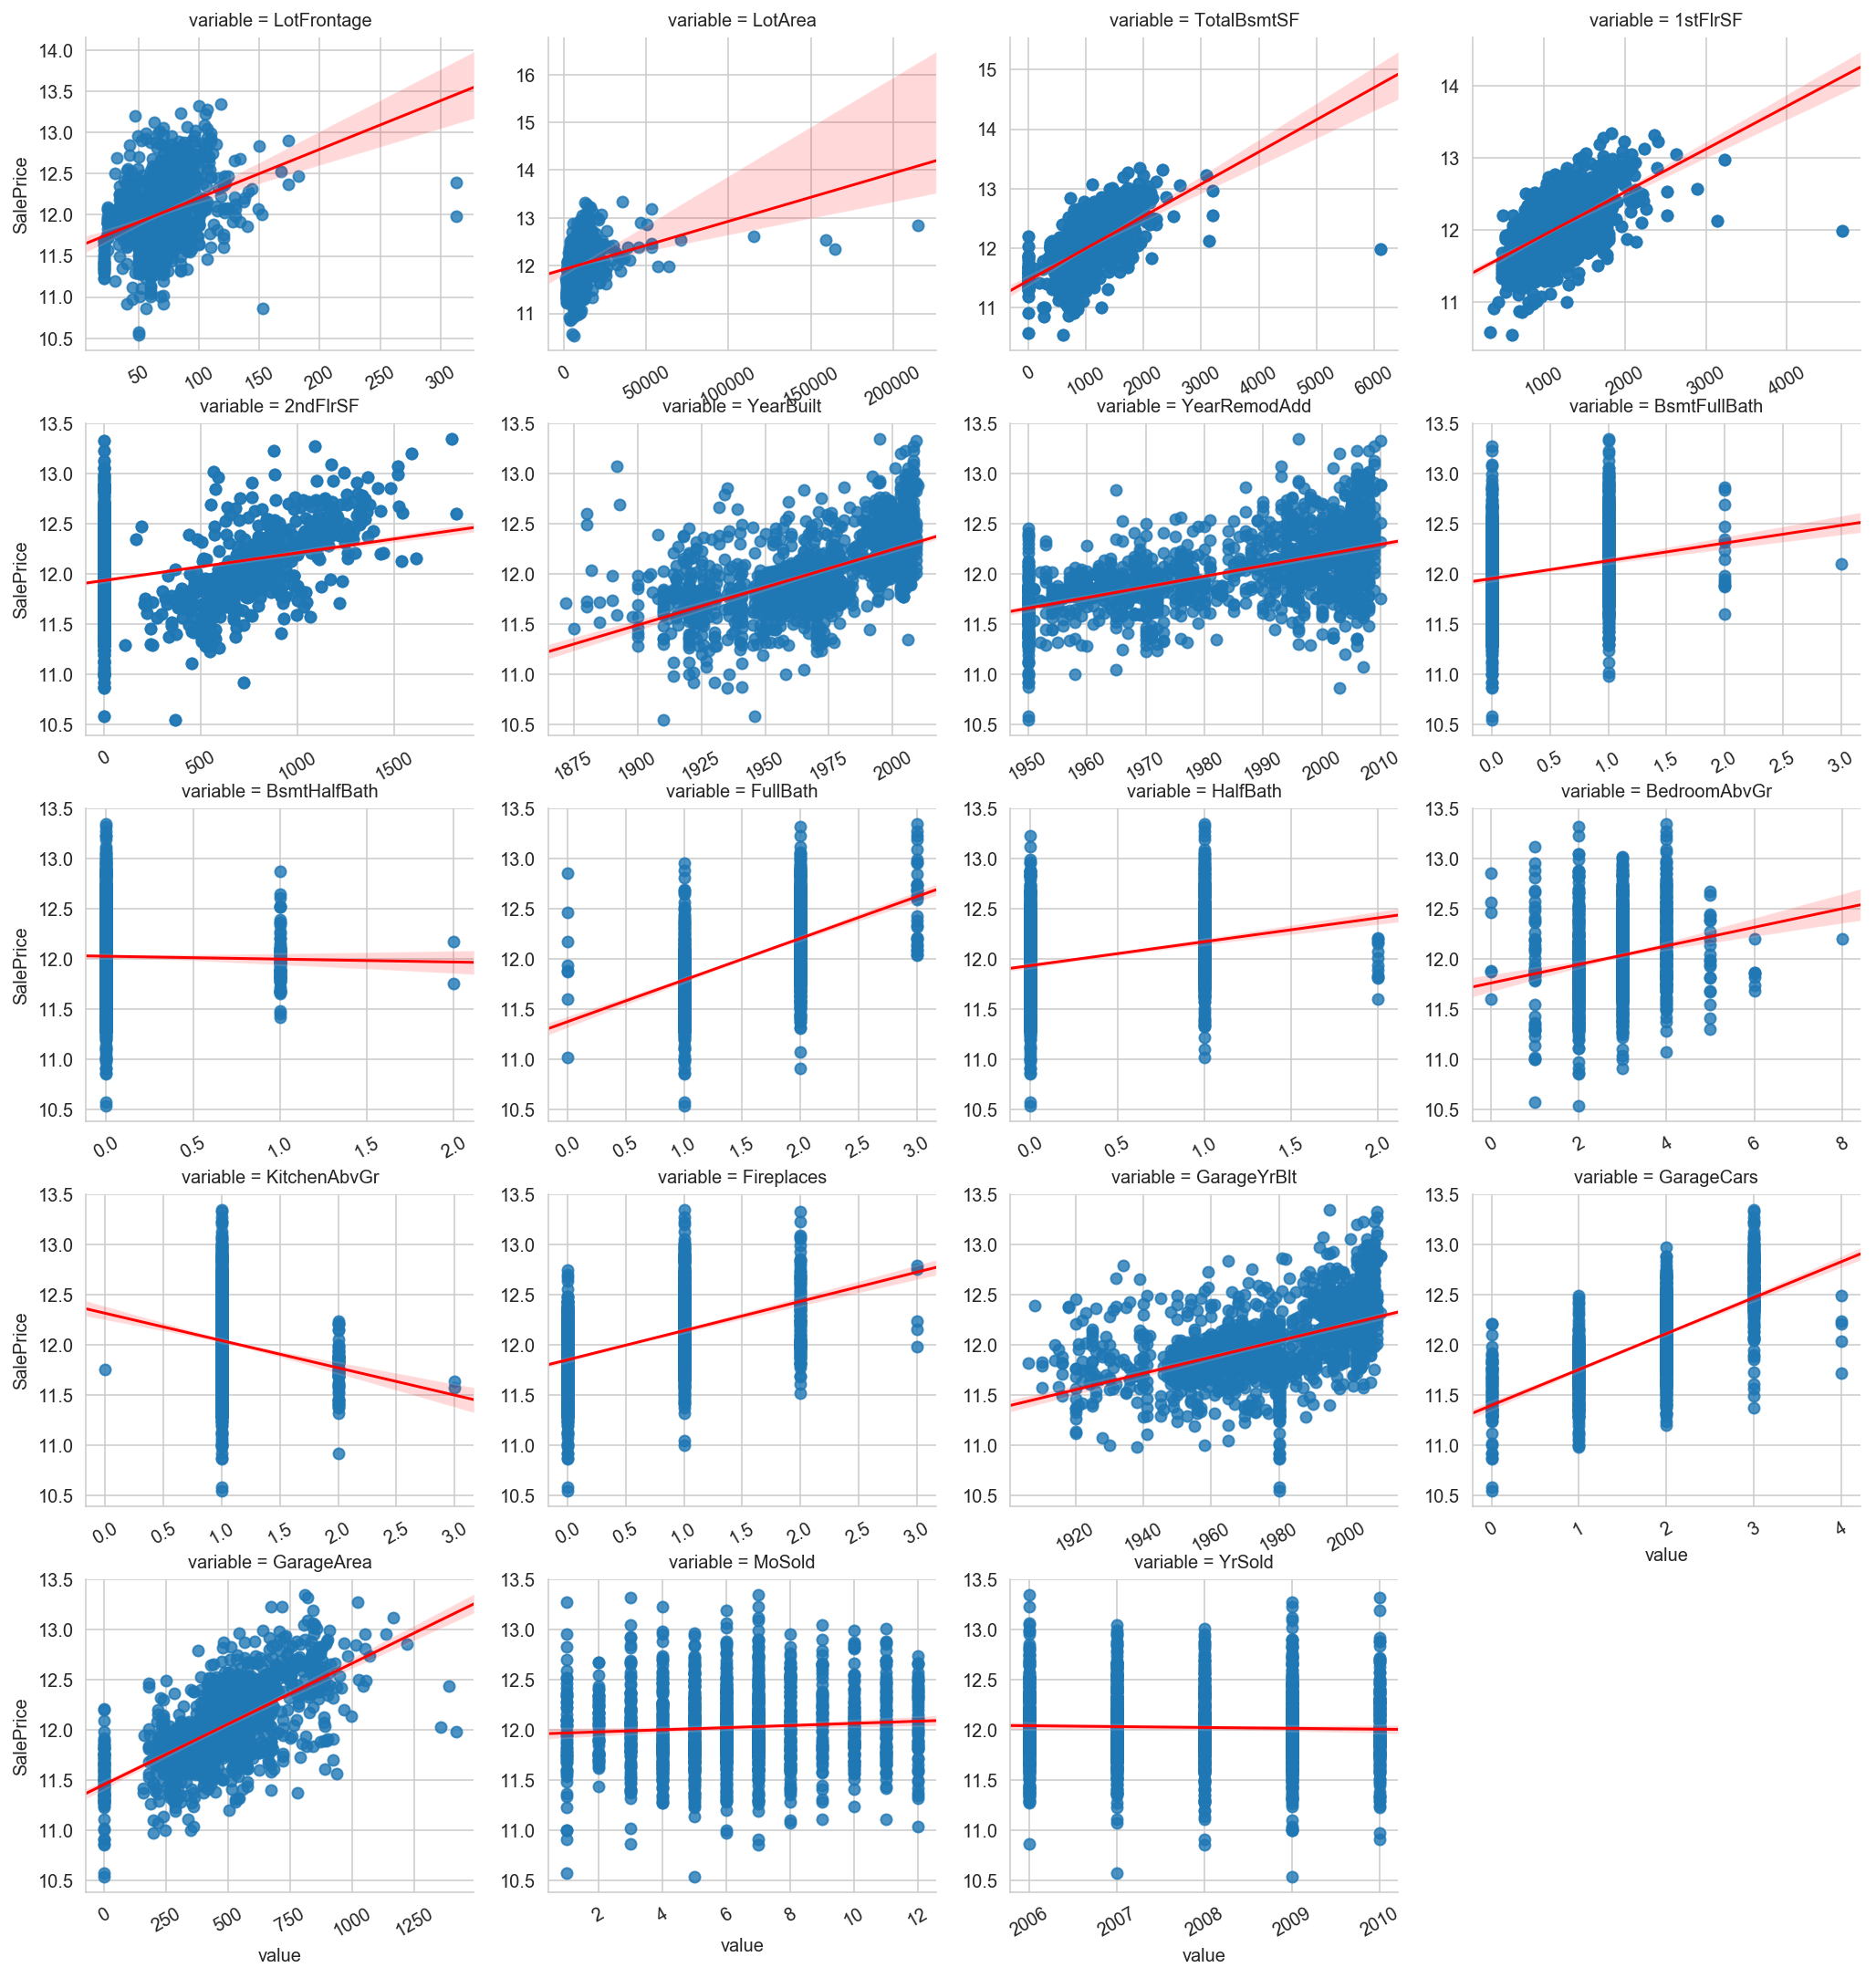

In [51]:
# Visual EDA by applying LOG function to non-categorical variables against price using regplot

noncat_plot = pd.melt(house_ffeatures_v2[ffeatures_noncat].join(np.log(house_ffeatures_v2['SalePrice'])), id_vars = 'SalePrice')

g = sns.FacetGrid(noncat_plot, col= 'variable', col_wrap= 4, sharex=False, sharey=False, aspect = 1.2)
g = g.map(sns.regplot, 'value','SalePrice', line_kws={'color':'red','linewidth':1.5});
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels

Indeed the relationships do appear to be more linear. 

In [52]:
house_ffeatures_v2['SalePrice'] = np.log(house_ffeatures_v2['SalePrice'])

**Let's identify and remove any outlier(s) that are way off**

In [53]:
house_ffeatures_v2[house_ffeatures_v2['TotalBsmtSF'] > 6000]

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1298,313.0,63887,2008,2008,6110,4692,950,2,0,2,...,0,0,1,0,0,0,0,0,0,1


In [54]:
house_ffeatures_v2[house_ffeatures_v2['LotFrontage'] > 300]

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
934,313.0,27650,1960,2007,585,2069,0,1,0,2,...,0,0,0,0,1,0,0,0,1,0
1298,313.0,63887,2008,2008,6110,4692,950,2,0,2,...,0,0,1,0,0,0,0,0,0,1


In [55]:
# Drop line 1298 due to it being a significant outlier

house_ffeatures_v2.drop(index = 1298, inplace = True)

**Let's do further feature engineering on time-related metrics to see if we can improve the model, given that the time-related metrics are not significant (based on beta coefficients) in the models in the previous section**

In [56]:
# create new feature on the age of the house
house_ffeatures_v2['age'] = house_ffeatures_v2['YrSold'] - house_ffeatures_v2['YearBuilt']

# create new feature on years since remodelling of house
house_ffeatures_v2['yrs_since_remod'] = house_ffeatures_v2['YrSold'] - house_ffeatures_v2['YearRemodAdd']

# create new feature on garage age
house_ffeatures_v2['garage_age'] = house_ffeatures_v2['YrSold'] - house_ffeatures_v2['GarageYrBlt']

In [57]:
house_ffeatures_v2.shape

(1447, 132)

**Split train/test datasets**

In [58]:
# Let's repeat the steps to test for the scores following the changes made in this section, incorporating the new features. 

# Split train test sets
train_set = house_ffeatures_v2[house_ffeatures_v2['YrSold'] < 2010]
X_train = train_set.drop(['SalePrice'], axis = 1)
y_train = train_set['SalePrice'].values

test_set = house_ffeatures_v2[house_ffeatures_v2['YrSold'] >= 2010]
X_test = test_set.drop(['SalePrice'], axis = 1)
y_test = test_set['SalePrice'].values


from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


**Run Linear Regression and Lasso Regression tests to see if scores are improved**

**i) Linear Regression model**

In [59]:
# Linear Regression model
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_train, y_train, cv = 10)
print(scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(scores), np.std(scores)))

y_pred = lr_model.predict(X_test)

print('R2 score when tested with test data is {}'.format(lr_model.score(X_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

[0.89182609 0.87834508 0.90255799 0.74549281 0.85326735 0.72598051
 0.87956185 0.86151875 0.87943536 0.83615185]
The mean cross validated R2 score for the training data is 0.8454, and the standard deviation is 0.0579
R2 score when tested with test data is 0.8977667011292207
Root mean squared error score is 0.12587623675543422


The score tested with test data for Linear Regression model has improved from 0.859 to 0.897, while mean cross validated R2 score with training data improved from 0.777 to 0.845. 

In [60]:
# Assess feature significance using OLS model
Xl = sm.add_constant(X_train)
model = sm.OLS(y_train,Xl).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     83.01
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:14:28   Log-Likelihood:                 880.29
No. Observations:                1275   AIC:                            -1505.
Df Residuals:                    1147   BIC:                            -845.3
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    16.2965      6.892      2.364      0.018       2.774      29.819
LotFrontage               0.0002      0.000      0.965      0.335      -0.000       0.001
LotArea                2.328e-06   5.52e-07      4.219      0.000    1.25e-06    3.41e-06
YearBuilt              1.375e-05      0.001      0.019      0.985      -0.001       0.001
YearRemodAdd              0.0003      0.001      0.491      0.623      -0.001       0.002
TotalBsmtSF               0.0001   2.46e-05      5.617      0.000    8.99e-05       0.000
1stFlrSF                  0.0003    2.7e-05      9.344      0.000       0.000       0.000
2ndFlrSF                  0.0003      3e-05      9.982      0.000       0.000       0.000
BsmtFullBath              0.0633      0.009      7.360      0.000       0.046       0.080
BsmtHalfBath              0.0415      0.016      2.575      0.010       0.010       0.073
FullBath                  0.0278      0.013      2.186      0.029       0.003       0.053
HalfBath                  0.0358      0.012      2.968      0.003       0.012       0.060
BedroomAbvGr             -0.0125      0.007     -1.759      0.079      -0.027       0.001
KitchenAbvGr             -0.1442      0.033     -4.399      0.000      -0.208      -0.080
Fireplaces                0.0483      0.008      6.339      0.000       0.033       0.063
GarageYrBlt              -0.0011      0.001     -1.572      0.116      -0.003       0.000
GarageCars                0.0304      0.013      2.371      0.018       0.005       0.056
GarageArea                0.0001    4.5e-05      2.718      0.007    3.41e-05       0.000
MoSold                    0.0008      0.001      0.539      0.590      -0.002       0.004
YrSold                   -0.0018      0.001     -1.316      0.188      -0.004       0.001
MSSubClass_30            -0.1079      0.027     -3.961      0.000      -0.161      -0.054
MSSubClass_40             0.0153      0.080      0.190      0.850      -0.142       0.173
MSSubClass_45            -0.1377      0.118     -1.166      0.244      -0.369       0.094
MSSubClass_50            -0.0526      0.052     -1.020      0.308      -0.154       0.049
MSSubClass_60            -0.0778      0.044     -1.769      0.077      -0.164       0.008
MSSubClass_70            -0.0044      0.046     -0.096      0.924      -0.096       0.087
MSSubClass_75            -0.0584      0.085     -0.685      0.493      -0.226       0.109
MSSubClass_80            -0.0143      0.071     -0.202      0.840      -0.153       0.125
MSSubClass_85             0.0469      0.063      0.745      0.456      -0.077       0.170
MSSubClass_90             0.0109      0.020      0.537      0.591      -0.029       0.051
MSSubClass_120           -0.0573      0.081     -0.709      0.478      -0.216       0.101
MSSubClass_160         

In [61]:
# Get p values < 0.05 to test 

# Get list of p values and remove the constant value
p_values = list(model.pvalues)
p_values.pop(0)

# Pass p value data into a dataframe
df_pvalue = pd.DataFrame(data = p_values, columns = ['p_value'], index = X_train.columns)

In [62]:
# filter for features whose p values <= 0.05. This will be used in the second part of this section on feature selection

df_pvalue = df_pvalue[df_pvalue['p_value'] <= 0.05]

**ii) Lasso Regression model**

In [63]:
# find optimal Lasso alpha and cross val R2 score using training data

optimal_lasso = LassoCV(n_alphas = 500, cv = 10)
optimal_lasso.fit(Xs_train, y_train)

lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv = 10)

print(lasso_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(lasso_scores), np.std(lasso_scores)))

lasso.fit(Xs_train, y_train)
y_pred = lasso.predict(Xs_test)

print('R2 score when tested with test data is {}'.format(lasso.score(Xs_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

[0.90868362 0.89733549 0.89835656 0.77057207 0.85385117 0.79473688
 0.87981133 0.86818902 0.8753969  0.85143181]
The mean cross validated R2 score for the training data is 0.8598, and the standard deviation is 0.0428
R2 score when tested with test data is 0.8988749121866796
Root mean squared error score is 0.1251921272689861


The score tested with test data for Lasso Regression model has improved from 0.855 to 0.899, while mean cross validated R2 score with training data improved from 0.7915 to 0.860. 

In [64]:
# Check percentage of variables zeroed out

print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))*100,'%')

Percent variables zeroed out: 58.778625954198475 %


In [65]:
# Lasso coefficients

lasso_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lasso.coef_, 'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(10)

,variable,coef,abs_coef
6,2ndFlrSF,0.115679,0.115679
5,1stFlrSF,0.091970,0.091970
4,TotalBsmtSF,0.068196,0.068196
129,yrs_since_remod,-0.056930,0.056930
13,Fireplaces,0.035402,0.035402
128,age,-0.033567,0.033567
7,BsmtFullBath,0.030136,0.030136
65,Neighborhood_NridgHt,0.029943,0.029943
16,GarageArea,0.029856,0.029856
12,KitchenAbvGr,-0.027554,0.027554


In [66]:
# filter for features whose coefficients are non-zero. This will be used in the second part of this section on feature selection

lasso_coefs_nonzero = list(lasso_coefs[lasso_coefs['coef'] != 0]['variable'])

In [67]:
# #Just in case

# train_set = house_ffeatures_v2[['GarageCars', 'GarageArea', 'FullBath', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd',
#                                'GarageYrBlt, 'Foundation_PConc', 'BsmtQual_TA', 'Fireplaces', 'LotArea', 'GarageType_Attchd',
#                                'GarageType_Detchd', 'MSSubClass_60', 'BsmtQual_Gd', 'SalePrice']][house_ffeatures_v2['YrSold'] < 2010]
# X_train = train_set.drop(['SalePrice'], axis = 1)
# y_train = np.log(train_set['SalePrice'].values)

# test_set = house_ffeatures_v2[['GarageCars', 'GarageArea', 'YearBuilt', 'FullBath', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd',
#                                'GarageYrBlt', 'Foundation_PConc', 'BsmtQual_TA', 'Fireplaces', 'LotArea', 'GarageType_Attchd',
#                                'GarageType_Detchd', 'MSSubClass_60', 'BsmtQual_Gd', 'SalePrice']][house_ffeatures_v2['YrSold'] >= 2010]
# X_test = test_set.drop(['SalePrice'], axis = 1)
# y_test = np.log(test_set['SalePrice'].values)

**We will now prioritise features based on the following methods and see if any helps to improve the scores.**
- 1) RFECV using Linear Regression as estimator
- 2) Feature selection from StatModel OLS based on features whose p value < 0.05
- 3) Feature selection following by filtering features eliminated by Lasso penalty

We will use both Linear Regression and Lasso Regression (Linear Regression for no. 1 only) to test performance. 

### i) Perform RFECV using Linear Regression as estimator

In [68]:
from sklearn.feature_selection import RFECV

lr = LinearRegression()

selector = RFECV(lr, step = 1, cv = 5)

selector = selector.fit(X_train, y_train)

print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Based on RFECV, no features should be eliminated, and thus no impact on scores. 

### ii) Feature selection from StatModel OLS based on features whose p value < 0.05

In [69]:
# Select features whose p-values <= 0.05 from previous section

df_pvalue

,p_value
LotArea,2.643923e-05
TotalBsmtSF,2.439155e-08
1stFlrSF,4.666925e-20
2ndFlrSF,1.468409e-22
BsmtFullBath,3.504290e-13
BsmtHalfBath,1.013432e-02
FullBath,2.901975e-02
HalfBath,3.054903e-03
KitchenAbvGr,1.186681e-05
Fireplaces,3.324542e-10


In [70]:
# Select relevant features for predictor variables

X_train_p = X_train[df_pvalue.index]
X_test_p = X_test[df_pvalue.index]

y_train_p = y_train
y_test_p = y_test

In [71]:
# Test using Linear Regression model
lr = LinearRegression()
lr_model = lr.fit(X_train_p, y_train_p)

scores = cross_val_score(lr, X_train_p, y_train_p, cv = 10)
print(scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(scores), np.std(scores)))

y_pred = lr_model.predict(X_test_p)

print('R2 score when tested with test data is {}'.format(lr_model.score(X_test_p, y_test_p)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test_p))))

[0.88792636 0.89026783 0.89462473 0.75497351 0.87327545 0.7119905
 0.87338105 0.86123636 0.87177619 0.85904946]
The mean cross validated R2 score for the training data is 0.8479, and the standard deviation is 0.0590
R2 score when tested with test data is 0.8826835787665278
Root mean squared error score is 0.1348425529332956


Compared to not having any features eliminated (R2 score of 0.8977), this Linear Regression model performs slightly weaker with R2 score of 0.882.

In [72]:
# Test using Lasso Regression model

optimal_lasso = LassoCV(n_alphas = 500, cv = 10)
optimal_lasso.fit(Xs_train, y_train)

lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv = 10)

print(lasso_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(lasso_scores), np.std(lasso_scores)))

lasso.fit(Xs_train, y_train)
y_pred = lasso.predict(Xs_test)

print('R2 score when tested with test data is {}'.format(lasso.score(Xs_test, y_test)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

[0.90868362 0.89733549 0.89835656 0.77057207 0.85385117 0.79473688
 0.87981133 0.86818902 0.8753969  0.85143181]
The mean cross validated R2 score for the training data is 0.8598, and the standard deviation is 0.0428
R2 score when tested with test data is 0.8988749121866796
Root mean squared error score is 0.1251921272689861


Compared to not having any features eliminated (R2 score of 0.899), this Lasso Regression model performs the same with R2 score of 0.899.

### iii) Feature selection following by filtering features eliminated by Lasso penalty

In [73]:
Xs_train

array([[-0.21753393, -0.19962485,  1.04058649, ..., -1.02343583,
        -0.85429852, -0.98743635],
       [ 0.49693223, -0.08795301,  0.14871073, ..., -0.16563457,
         0.40959205,  0.08716773],
       [-0.0746407 ,  0.07227181,  0.97452162, ..., -0.95745112,
        -0.80568735, -0.9047745 ],
       ...,
       [-0.36042716, -0.2918755 ,  1.07361892, ..., -1.02343583,
        -0.9029097 , -0.98743635],
       [-0.36042716, -0.25138232,  0.90845675, ..., -0.92445876,
        -0.75707617, -0.86344357],
       [ 0.25877684, -0.0552283 , -0.21464606, ...,  0.23027371,
         0.99292616,  0.58313885]])

In [74]:
# Select relevant features for predictor variables

X_train_l = X_train[lasso_coefs_nonzero]
X_test_l = X_test[lasso_coefs_nonzero]

y_train_l = y_train
y_test_l = y_test

# Transform X variables
Xs_train_l = ss.fit_transform(X_train_l)
Xs_test_l = ss.transform(X_test_l)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [75]:
y_train

array([12.24769432, 12.10901093, 12.31716669, ..., 12.1281111 ,
       12.07254125, 11.90158345])

In [76]:
X_train_l.shape

(1275, 54)

In [77]:
# Test using Linear Regression model
lr = LinearRegression()
lr_model = lr.fit(X_train_l, y_train_l)

scores = cross_val_score(lr, X_train_l, y_train_l, cv = 10)
print(scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(scores), np.std(scores)))

y_pred = lr_model.predict(X_test_l)

print('R2 score when tested with test data is {}'.format(lr_model.score(X_test_l, y_test_l)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test_l))))

[0.90940377 0.89640373 0.90994615 0.76979092 0.86104627 0.75497161
 0.88370187 0.876933   0.88325427 0.85828542]
The mean cross validated R2 score for the training data is 0.8604, and the standard deviation is 0.0518
R2 score when tested with test data is 0.8976553661758556
Root mean squared error score is 0.12594475949535175


Compared to not having any features eliminated (R2 score of 0.8977), this Linear Regression model performs almost the same with an R2 score of 0.8976. 

In [78]:
# Test using Lasso Regression model

optimal_lasso = LassoCV(n_alphas = 500, cv = 10)
optimal_lasso.fit(Xs_train_l, y_train_l)

lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train_l, y_train_l, cv = 10)

print(lasso_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(lasso_scores), np.std(lasso_scores)))

lasso.fit(Xs_train_l, y_train_l)
y_pred = lasso.predict(Xs_test_l)

print('R2 score when tested with test data is {}'.format(lasso.score(Xs_test_l, y_test_l)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test_l))))

[0.91082206 0.89791834 0.90760229 0.78188082 0.86103747 0.7722494
 0.88311758 0.87523192 0.88179364 0.85676758]
The mean cross validated R2 score for the training data is 0.8628, and the standard deviation is 0.0461
R2 score when tested with test data is 0.8992155113630002
Root mean squared error score is 0.12498111978731927


Compared to not having any features eliminated (R2 score of 0.899), this Lasso Regression model performs marginally better with R2 score of 0.8992. 

### Conclusion

- Lasso regression (after 58% of features eliminated by Lasso penalty) performs the best with test data with an R2 score of 0.8992. It also has the lowest root mean square error score of 0.1249. 
- Feature engineering on time-related metrics, cutting distant outliers, and applying log function on the target variable ('SalePrice') proved to be helpful in improving the score by almost 6%. 
- The top 10 most relevant features in predicting price, as determined by Lasso Regression based on absolute value of coefficients can be found below. As expected, size matters as features like FloorSF, BasementSF and GarageArea feature prominently

In [79]:
lasso_coefs.head(10)

,variable,coef,abs_coef
6,2ndFlrSF,0.115679,0.115679
5,1stFlrSF,0.091970,0.091970
4,TotalBsmtSF,0.068196,0.068196
129,yrs_since_remod,-0.056930,0.056930
13,Fireplaces,0.035402,0.035402
128,age,-0.033567,0.033567
7,BsmtFullBath,0.030136,0.030136
65,Neighborhood_NridgHt,0.029943,0.029943
16,GarageArea,0.029856,0.029856
12,KitchenAbvGr,-0.027554,0.027554


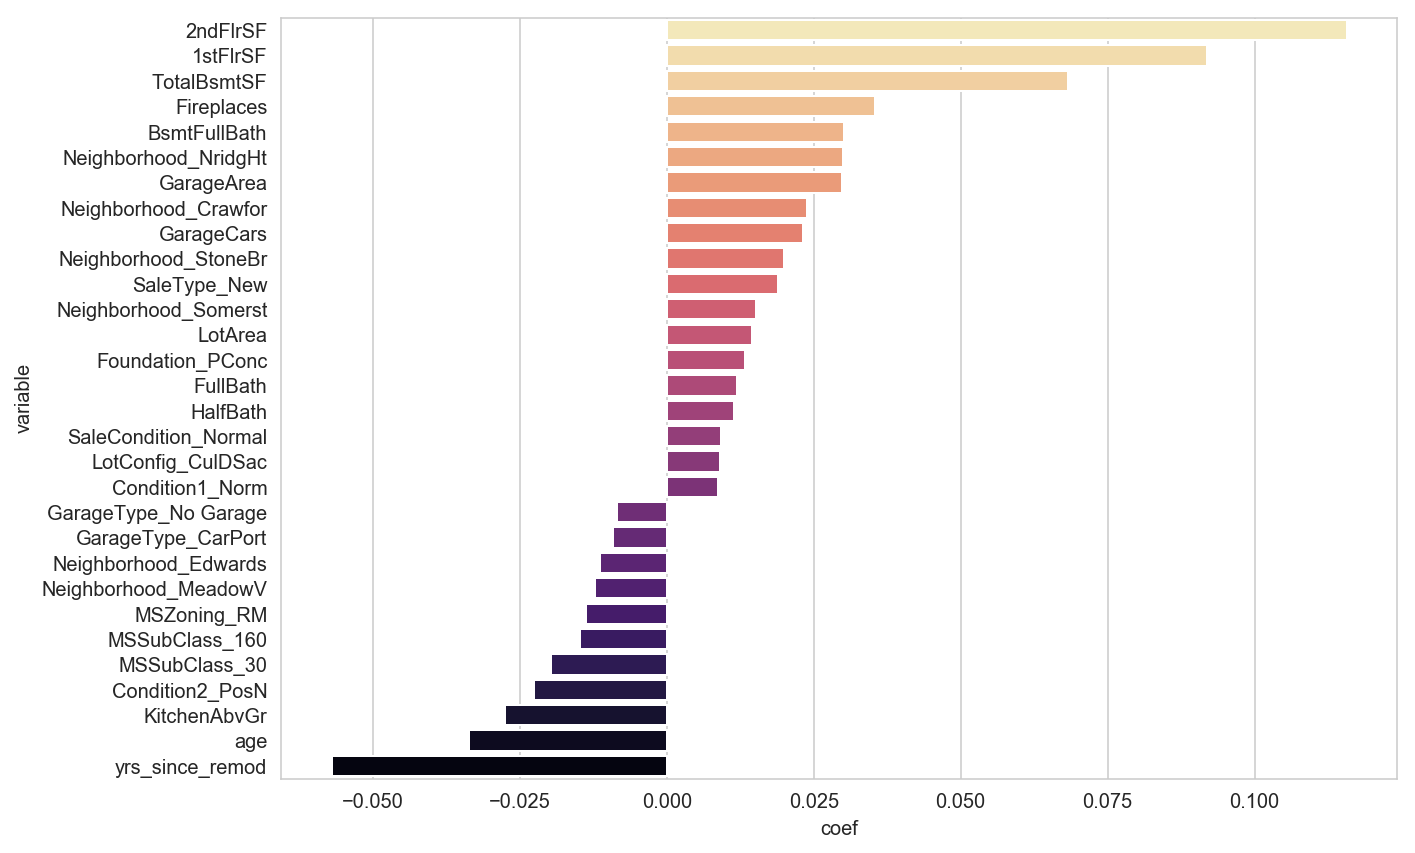

In [80]:
# Comparison of filtered features
plt.figure(figsize=(10,7))
sns.barplot(y='variable',x='coef',data=lasso_coefs[0:30].sort_values('coef',ascending=False), palette='magma_r');

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


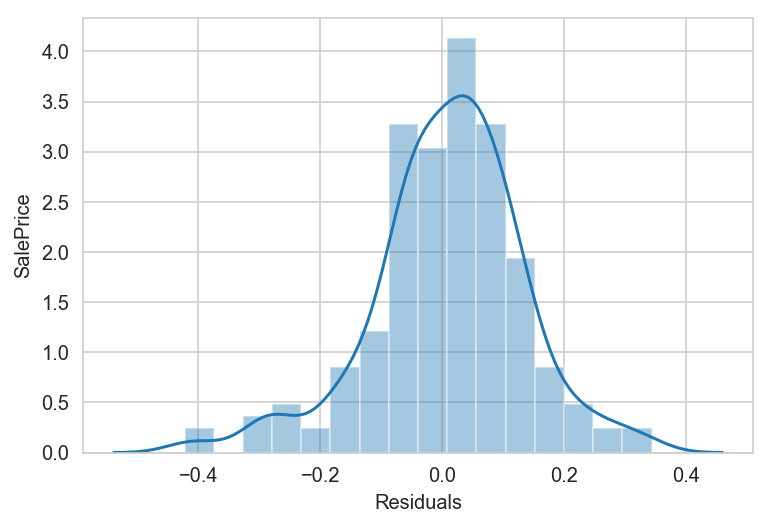

In [81]:
# Check for normal distribution of residuals for multi linear regression

sns.distplot(y_test_l - y_pred)
plt.xlabel('Residuals')
plt.ylabel('SalePrice');

The residuals are approximately normally distributed, with a slight left skew. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

**Based on the R2 of 0.899 from the best model in question 1, fixed characteristics can explain almost 90% of variance in the Sale Price. That means that ~10% of variance is still unexplained.**

**In this question, we will explore to what extent the renovat-able features can explain the remaining ~10% of variance.**

<div class="alert alert-warning">

###  Prepare features to be used in this question. ###

</div>

In [82]:
# Using the best model in qns 1, perform prediction of SalePrice on the entire dataset

# join train and test data from previously
Xs_l = pd.concat([pd.DataFrame(Xs_train_l),pd.DataFrame(Xs_test_l)]).reset_index(drop=True)
Xs_l.columns = lasso_coefs_nonzero

y_l = pd.concat([pd.DataFrame(y_train_l),pd.DataFrame(y_test_l)]).reset_index(drop=True)
y_l.columns = ['SalePrice']

In [83]:
Xs_l.head()

,2ndFlrSF,1stFlrSF,TotalBsmtSF,yrs_since_remod,Fireplaces,age,BsmtFullBath,Neighborhood_NridgHt,GarageArea,KitchenAbvGr,...,Neighborhood_BrkSide,BldgType_Twnhs,LandContour_HLS,Neighborhood_Sawyer,Neighborhood_Gilbert,Neighborhood_Timber,SaleCondition_Family,MSSubClass_70,Condition2_Norm,SaleType_CWD
0,1.167026,-0.817359,-0.474719,-0.854299,-0.971441,-1.023436,1.135649,-0.239194,0.342115,-0.205312,...,-0.214335,-0.17527,-0.195636,-0.218308,-0.246439,-0.163003,-0.119665,-0.210300,0.101494,-0.056099
1,-0.804835,0.275455,0.500444,0.409592,0.604370,-0.165635,-0.802708,-0.239194,-0.069568,-0.205312,...,-0.214335,-0.17527,-0.195636,-0.218308,-0.246439,-0.163003,-0.119665,-0.210300,0.101494,-0.056099
2,1.194734,-0.645093,-0.320998,-0.805687,0.604370,-0.957451,1.135649,-0.239194,0.622807,-0.205312,...,-0.214335,-0.17527,-0.195636,-0.218308,-0.246439,-0.163003,-0.119665,-0.210300,0.101494,-0.056099
3,0.940747,-0.534735,-0.714906,0.652648,0.604370,1.813907,1.135649,-0.239194,0.781866,-0.205312,...,-0.214335,-0.17527,-0.195636,-0.218308,-0.246439,-0.163003,-0.119665,4.755114,0.101494,-0.056099
4,1.626512,-0.039469,0.219424,-0.708465,0.604370,-0.924459,1.135649,-0.239194,1.689438,-0.205312,...,-0.214335,-0.17527,-0.195636,-0.218308,-0.246439,-0.163003,-0.119665,-0.210300,0.101494,-0.056099


In [84]:
y_l.head()

,SalePrice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216


In [85]:
# Predicted price based on best model

y_l['PredictPrice'] = lasso.predict(Xs_l)

In [86]:
y_l.head()

,SalePrice,PredictPrice
0,12.247694,12.221128
1,12.109011,12.078887
2,12.317167,12.311807
3,11.849398,12.116202
4,12.429216,12.581501


In [87]:
# Convert price variables to exponential variables from log values before
y_l['SalePrice'] = np.exp(y_l['SalePrice']) 
y_l['PredictPrice'] = np.exp(y_l['PredictPrice'])

# Calculate Residuals
y_l['Residual'] = y_l['SalePrice'] - y_l['PredictPrice']

In [88]:
y_l.head()

,SalePrice,PredictPrice,Residual
0,208500.0,203033.806239,5466.193761
1,181500.0,176114.110198,5385.889802
2,223500.0,222305.332727,1194.667273
3,140000.0,182809.840577,-42809.840577
4,250000.0,291122.888337,-41122.888337


In [89]:
# Create df of renovat-able features from original dataset

non_fixed_attributes = ['OverallQual', 'OverallCond','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
'MasVnrType', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF','Heating', 'HeatingQC','CentralAir',\
'Electrical', 'LowQualFinSF', 'GrLivArea', 'KitchenQual', 'TotRmsAbvGrd','Functional','GarageFinish','GarageQual', 'GarageCond',\
'PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', \
'PoolArea']


house_vfeatures = house[non_fixed_attributes]

# include YrSold to facilitate spliting of training dataset (prior to 2010) and testing datasets (2010) for this question
house_vfeatures['YrSold'] = house['YrSold']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [90]:
house_vfeatures.tail()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold
1455,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,...,TA,TA,Y,0,40,0,0,0,0,2007
1456,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,...,TA,TA,Y,349,0,0,0,0,0,2010
1457,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,...,TA,TA,Y,0,60,0,0,0,0,2010
1458,5,6,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,...,TA,TA,Y,366,0,112,0,0,0,2010
1459,5,6,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,...,TA,TA,Y,736,68,0,0,0,0,2008


In [91]:
# drop 3 outliers rows per qns 1 (index rows 691, 1182 and 1298)

house_vfeatures.drop(index = [691, 1182, 1298], inplace = True)
house_vfeatures.reset_index(drop = True, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [92]:
house_vfeatures.tail()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold
1442,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,...,TA,TA,Y,0,40,0,0,0,0,2007
1443,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,...,TA,TA,Y,349,0,0,0,0,0,2010
1444,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,...,TA,TA,Y,0,60,0,0,0,0,2010
1445,5,6,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,...,TA,TA,Y,366,0,112,0,0,0,2010
1446,5,6,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,...,TA,TA,Y,736,68,0,0,0,0,2008


In [93]:
# Include residuals/SalePrice variance into dataset

house_vfeatures['SalePrice_variance'] = y_l['Residual']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
house_vfeatures.shape

(1447, 38)

### Perform EDA for renovat-able features

In [95]:
house_vfeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 38 columns):
OverallQual           1447 non-null int64
OverallCond           1447 non-null int64
RoofStyle             1447 non-null object
RoofMatl              1447 non-null object
Exterior1st           1447 non-null object
Exterior2nd           1447 non-null object
MasVnrType            1439 non-null object
MasVnrArea            1439 non-null float64
ExterQual             1447 non-null object
ExterCond             1447 non-null object
BsmtCond              1410 non-null object
BsmtExposure          1409 non-null object
BsmtFinType1          1410 non-null object
BsmtFinSF1            1447 non-null int64
BsmtFinType2          1409 non-null object
BsmtFinSF2            1447 non-null int64
BsmtUnfSF             1447 non-null int64
Heating               1447 non-null object
HeatingQC             1447 non-null object
CentralAir            1447 non-null object
Electrical            1446 non-null o

**Groups of features with null values are:**
- MasVnrType and MasVnrArea
- BsmdCond, BsmtExposure, BsmtFinType1, BsmtFinType2
- Electrical
- GarageFinish, GarageQual, GarageCond

**i) Dealing with null values for MasVnrType and MasVnrArea**

In [96]:
house_vfeatures['MasVnrType'].value_counts()

None       853
BrkFace    444
Stone      127
BrkCmn      15
Name: MasVnrType, dtype: int64

In [97]:
house_vfeatures[house_vfeatures['MasVnrType'].isnull()]

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice_variance
231,6,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,...,TA,Y,288,48,0,0,0,0,2010,-15299.643611
525,6,3,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,...,TA,Y,0,0,200,0,0,0,2007,-3738.183891
645,7,6,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,...,TA,Y,0,0,0,0,0,0,2008,14034.826939
927,7,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,...,TA,Y,0,41,0,0,0,0,2009,-39915.823600
964,7,5,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,...,TA,Y,0,120,0,0,0,0,2008,-10258.064187
968,7,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,...,TA,Y,0,116,0,0,0,0,2007,-34317.116398
1232,10,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,...,TA,Y,216,229,0,0,0,0,2006,960.976768
1267,8,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,...,TA,Y,0,211,0,0,0,0,2008,15692.965707


In [98]:
# fill null MasVnrType with 'None' value and MasVnrArea with 0, given that the null rows for both attributes are consistent,
# across the whole dataset

house_vfeatures['MasVnrType'].fillna('None', inplace = True)
house_vfeatures['MasVnrArea'].fillna(0, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**ii) Dealing with null values for BsmdCond, BsmtExposure, BsmtFinType1, BsmtFinType2**

In [99]:
# Check consistency of null values in basement related features

house_vfeatures[house_vfeatures['BsmtExposure'].isnull()].iloc[:, 10:]

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice_variance
17,NaN,NaN,NaN,0,NaN,0,0,GasA,TA,Y,...,TA,Y,0,0,0,0,0,0,2006,4594.305885
38,NaN,NaN,NaN,0,NaN,0,0,GasA,TA,N,...,NaN,N,0,0,0,0,0,0,2008,-7451.173113
88,NaN,NaN,NaN,0,NaN,0,0,GasA,TA,Y,...,TA,Y,0,29,0,0,0,0,2006,50024.728957
99,NaN,NaN,NaN,0,NaN,0,0,GasA,TA,Y,...,TA,Y,0,0,0,0,0,0,2009,-13983.878240
153,NaN,NaN,NaN,0,NaN,0,0,GasA,TA,Y,...,TA,Y,0,0,0,0,0,0,2006,208573.990097
179,NaN,NaN,NaN,0,NaN,0,0,GasA,Ex,Y,...,TA,Y,116,0,0,180,0,0,2007,-10909.934144
256,NaN,NaN,NaN,0,NaN,0,0,GasA,Gd,Y,...,TA,Y,0,45,0,0,0,0,2008,769.399210
339,NaN,NaN,NaN,0,NaN,0,0,Wall,Fa,N,...,TA,Y,0,0,0,0,0,0,2006,-29990.313348
359,NaN,NaN,NaN,0,NaN,0,0,GasA,Ex,Y,...,TA,Y,0,0,177,0,0,0,2009,-3396.548442
368,NaN,NaN,NaN,0,NaN,0,0,GasA,TA,Y,...,TA,N,0,59,0,0,0,0,2008,-7520.077207


In [100]:
house_vfeatures['BsmtExposure'].value_counts()

No    947
Av    218
Gd    132
Mn    112
Name: BsmtExposure, dtype: int64

In [101]:
# Fill BsmtExposure NA values with 

In [102]:
house_vfeatures['BsmtCond'].value_counts()

TA    1300
Gd      65
Fa      43
Po       2
Name: BsmtCond, dtype: int64

In [103]:
house_vfeatures['BsmtFinType1'].value_counts()

Unf    424
GLQ    415
ALQ    220
BLQ    147
Rec    130
LwQ     74
Name: BsmtFinType1, dtype: int64

In [104]:
house_vfeatures['BsmtFinType2'].value_counts()

Unf    1243
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [105]:
# In each of the 4 basement features, NA is a valid category representing 'No Basement' according to documentation. 
# Let's fill these 4 features with NA as category.

house_vfeatures['BsmtExposure'].fillna('NA', inplace = True)
house_vfeatures['BsmtCond'].fillna('NA', inplace = True)
house_vfeatures['BsmtFinType1'].fillna('NA', inplace = True)
house_vfeatures['BsmtFinType2'].fillna('NA', inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**iii) Dealing with null values for Electrical**

In [106]:
house_vfeatures[house_vfeatures['Electrical'].isnull()].iloc[:, 20:]

,Electrical,LowQualFinSF,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice_variance
1366,NaN,0,1394,Gd,7,Typ,Fin,TA,TA,Y,100,0,0,0,0,0,2008,15892.062579


In [107]:
house_vfeatures['Electrical'].value_counts()

SBrkr    1325
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [108]:
# fill null Electrical with 'SBrkr' value, given that it is the most common category

house_vfeatures['Electrical'].fillna('SBrkr', inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**iv) Dealing with null values for GarageFinish, GarageQual, GarageCond**

In [109]:
house_vfeatures[house_vfeatures['GarageFinish'].isnull()].iloc[:, 25:]

,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice_variance
38,Typ,NaN,NaN,NaN,N,0,0,0,0,0,0,2008,-7451.173113
47,Typ,NaN,NaN,NaN,N,0,0,102,0,0,0,2009,-10779.957904
77,Typ,NaN,NaN,NaN,Y,0,0,0,0,0,0,2010,-1263.807635
87,Typ,NaN,NaN,NaN,Y,0,0,0,0,0,0,2007,-10680.098065
96,Typ,NaN,NaN,NaN,Y,352,0,0,0,0,0,2010,-5980.899888
105,Typ,NaN,NaN,NaN,N,0,0,144,0,0,0,2007,23440.642210
122,Typ,NaN,NaN,NaN,N,53,0,0,0,0,0,2006,-12762.229942
124,Typ,NaN,NaN,NaN,N,0,0,0,0,0,0,2007,-2679.668409
137,Typ,NaN,NaN,NaN,Y,0,0,0,0,0,0,2010,-9645.606782
145,Typ,NaN,NaN,NaN,Y,0,0,0,0,0,0,2008,-6177.203343


In [110]:
# In each of the 3 garage features, NA is a valid category representing 'No Garage' according to documentation. 
# Let's fill these 3 features with NA as category.

house_vfeatures['GarageFinish'].fillna('NA', inplace = True)
house_vfeatures['GarageQual'].fillna('NA', inplace = True)
house_vfeatures['GarageCond'].fillna('NA', inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [111]:
# check no more null values

house_vfeatures.isnull().any().any()

False

In [112]:
# Convert categorical renovat-able features into dummies - all object categories

vfeatures_cat =  ['RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
'MasVnrType','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
'BsmtFinType1', 'BsmtFinType2','Heating', 'HeatingQC','CentralAir',\
'Electrical', 'KitchenQual','Functional','GarageFinish','GarageQual', 'GarageCond',\
'PavedDrive']


# Selecting categories with highest frequency from categorical features to drop
drop_dummies = []

for col in vfeatures_cat:
    drop_dummies.append(col+'_'+house_vfeatures[col].value_counts().index[0])

drop_dummies

['RoofStyle_Gable',
 'RoofMatl_CompShg',
 'Exterior1st_VinylSd',
 'Exterior2nd_VinylSd',
 'MasVnrType_None',
 'ExterQual_TA',
 'ExterCond_TA',
 'BsmtCond_TA',
 'BsmtExposure_No',
 'BsmtFinType1_Unf',
 'BsmtFinType2_Unf',
 'Heating_GasA',
 'HeatingQC_Ex',
 'CentralAir_Y',
 'Electrical_SBrkr',
 'KitchenQual_TA',
 'Functional_Typ',
 'GarageFinish_Unf',
 'GarageQual_TA',
 'GarageCond_TA',
 'PavedDrive_Y']

In [113]:
# Create dummies

house_vfeatures = pd.get_dummies(data = house_vfeatures, columns = vfeatures_cat)

In [114]:
# Drop dummies for categories with highest frequencies

house_vfeatures.drop(drop_dummies, axis = 1, inplace = True)

In [115]:
house_vfeatures.shape

(1447, 125)

<div class="alert alert-warning">

###  i) Evaluate the effect in dollars of the renovate-able features.  ###

</div>



**We will run the following models to assess the effect of renovate-able features on the residuals.**
- 1) Linear Regression
- 2) Lasso Regression (with feature elimination)

**1) Linear Regression**

In [116]:
# Split dataset into training and testing dataset

train_set = house_vfeatures[house_vfeatures['YrSold'] < 2010]
X_train_r = train_set.drop(['SalePrice_variance', 'YrSold'], axis = 1)
y_train_r = train_set['SalePrice_variance'].values

test_set = house_vfeatures[house_vfeatures['YrSold'] >= 2010]
X_test_r = test_set.drop(['SalePrice_variance', 'YrSold'], axis = 1)
y_test_r = test_set['SalePrice_variance'].values

ss = StandardScaler()

Xs_train_r = ss.fit_transform(X_train_r)
Xs_test_r = ss.transform(X_test_r)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [117]:
y_train_r

array([5466.19376111, 5385.88980212, 1194.66727333, ..., 9903.7445139 ,
       4468.61763304, 4184.45948445])

In [118]:
# Test using Linear Regression model
lr = LinearRegression()
lr_model = lr.fit(X_train_r, y_train_r)

scores = cross_val_score(lr, X_train_r, y_train_r, cv = 10)
print(scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(scores), np.std(scores)))

y_pred = lr_model.predict(X_test_r)

print('R2 score when tested with test data is {}'.format(lr_model.score(X_test_r, y_test_r)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test_r))))

[-0.22276031 -0.0747668  -0.15701735 -0.04880067 -0.10868618 -0.50669793
 -0.29608661 -0.09299583 -0.1532983  -0.17050381]
The mean cross validated R2 score for the training data is -0.1832, and the standard deviation is 0.1281
R2 score when tested with test data is -0.17873837950606997
Root mean squared error score is 27436.70088977837


The R2 score is pretty poor, implying that renovat-able features are not predictive of the residuals 

**2) Lasso Regression (with feature elimination)**

In [119]:
# find optimal Lasso alpha and cross val R2 score using training data

# NB: We don't need to scale the X values 

optimal_lasso = LassoCV(n_alphas = 100, cv = 10)
optimal_lasso.fit(Xs_train_r, y_train_r)

lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train_r, y_train_r, cv = 10)

print(lasso_scores)
print('The mean cross validated R2 score for the training data is {:0.4f}, and the standard deviation is {:0.4f}'.format\
      (np.mean(lasso_scores), np.std(lasso_scores)))

lasso.fit(Xs_train_r, y_train_r)
y_pred = lasso.predict(Xs_test_r)

print('R2 score when tested with test data is {}'.format(lasso.score(Xs_test_r, y_test_r)))
print('Root mean squared error score is {}'.format(np.sqrt(mean_squared_error(y_pred, y_test_r))))

[-5.87029533e-06 -3.86380478e-04  5.34056902e-04 -7.65472933e-03
 -5.18809339e-03 -3.39507107e-02  4.00912344e-04 -1.01552054e-02
 -1.01622702e-02 -6.26535596e-03]
The mean cross validated R2 score for the training data is -0.0073, and the standard deviation is 0.0098
R2 score when tested with test data is -0.003145747428738188
Root mean squared error score is 25310.760520433763


In [120]:
# Check percentage of variables zeroed out

print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))*100,'%')

Percent variables zeroed out: 99.1869918699187 %


In [121]:
# Lasso coefficients

lasso_coefs = pd.DataFrame({'variable':X_train_r.columns, 'coef':lasso.coef_, 'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head()

,variable,coef,abs_coef
23,RoofMatl_Tar&Grv,-343.797591,343.797591
0,OverallQual,-0.000000,0.000000
78,BsmtFinType1_Rec,-0.000000,0.000000
90,HeatingQC_Fa,-0.000000,0.000000
89,Heating_Wall,-0.000000,0.000000


Given that >99% of all features have been eliminated, and variables having a very negligible effect on the residuals, it can be concluded that the renovatable features cannot be used to predict the variance in the actual SalePrice and predicted SalePrice as determined in Qns 1. 

<div class="alert alert-warning">

###  ii) How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. ###

</div>

In this scenario, the models utilised in this question is not useful in predicting whether to buy a property or not. That said, the best model in the first question has very strong predictive ability, which indicates that fixed features, in particular, the area size of the different floors are most useful in predicting sale price.

There are two situations theoretically where a company would consider purchasing a property based on data points provided in this project. 
- 1) If the property's asking price is lower than the predicted price given its current condition. This implies that the property is undervalued and thus can be flipped for a profit.
- 2) If the property can be renovated and subsequently sold for a profit after factoring in the purchase price and renovation cost

In the second case, based on the conclusions in this question, it does not make sense for my company to buy a property and renovate it in view of selling for a profit, given that renovation does not have any predictive power on sale price. 

<div class="alert alert-warning">

###  iii) Investigate how much of the variance in price remaining is explained by these features.. ###

</div>

Per part i)

<div class="alert alert-warning">

###  iv) Do you trust your model? Should it be used to evaluate which properties to buy and fix up? ###

</div>



Theoretically, renovating a house should have a positive impact on the price. However, the model in this question does not seem to suggest a relationship. 

That said, it can certainly be used to predict potential sale price on the basis of the 'as-is' condition of the property, given the strong predictive power of using fixed features. 

Meanwhile, it is important to note that there are other important extrinsic factors that would affect the property price as well. This includes the location of the property, surrounding amenities, economic climate (i.e. interest rate levels), and seasonality factors of sales. 

A more holistic review should be conducted before any significant investment is undertaken, that may involve a predicted sales price of property based on this model. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

<div class="alert alert-warning">

### i) Determine which features predict the `Abnorml` category in the `SaleCondition` feature. ###

</div>

**Data Preparation**

In [122]:
# Model & Traditional Model Eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

# Resampling Methods
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline

In [123]:
# Cleaning up original housing dataset for this question based on changes made to subsets of the original dataset previously

house = pd.read_csv('./housing.csv')

house.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'], axis = 1, inplace = True)

house = house[house['MSZoning'].isin(['FV', 'RH', 'RL', 'RP', 'RM'])]

house.drop(columns = 'Id', axis = 1, inplace = True)

house['BsmtQual'].fillna('No Bsmnt', inplace = True)
house['GarageType'].fillna('No Garage', inplace = True)
house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace = True)
house['GarageYrBlt'].fillna(house['GarageYrBlt'].median(), inplace = True)

house = house[~(house['SalePrice'] > 700000)]

house.drop(index = 1298, inplace = True)

house['age'] = house['YrSold'] - house['YearBuilt']

house['yrs_since_remod'] = house['YrSold'] - house['YearRemodAdd']

house['garage_age'] = house['YrSold'] - house['GarageYrBlt']

house['MasVnrType'].fillna('None', inplace = True)
house['MasVnrArea'].fillna(0, inplace = True)

house['BsmtExposure'].fillna('NA', inplace = True)
house['BsmtCond'].fillna('NA', inplace = True)
house['BsmtFinType1'].fillna('NA', inplace = True)
house['BsmtFinType2'].fillna('NA', inplace = True)

house['Electrical'].fillna('SBrkr', inplace = True)

house['GarageFinish'].fillna('NA', inplace = True)
house['GarageQual'].fillna('NA', inplace = True)
house['GarageCond'].fillna('NA', inplace = True)

In [124]:
house.shape

(1447, 77)

In [125]:
# Convert categories of fixed features and renovatable features into dummies

ffeatures_cat = ['MSSubClass','MSZoning','Street','LotShape','LandContour', 'Utilities', 'LotConfig', \
                 'LandSlope','Neighborhood','Condition1', 'Condition2','BldgType','HouseStyle',\
                 'Foundation','BsmtQual','GarageType','SaleType']

vfeatures_cat =  ['RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
                  'MasVnrType','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
                  'BsmtFinType1', 'BsmtFinType2','Heating', 'HeatingQC','CentralAir',\
                  'Electrical', 'KitchenQual','Functional','GarageFinish','GarageQual', 'GarageCond',\
                  'PavedDrive']

all_categories = ffeatures_cat + vfeatures_cat

house = pd.get_dummies(data = house, columns = all_categories, drop_first = True)

In [126]:
house.shape

(1447, 251)

In [127]:
# assess class imbalance

house['SaleCondition'].value_counts()

Normal     1193
Partial     124
Abnorml      95
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [128]:
# Crete a boolean column to show whether a sale is abnormal or not

house['abnormal_sale'] = house['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0)

In [131]:
house.groupby('abnormal_sale').count()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y
abnormal_sale,,,,,,,,,,,,,,,,,,,,,
0,1352,1352,1352,1352,1352,1352,1352,1352,1352,1352,...,1352,1352,1352,1352,1352,1352,1352,1352,1352,1352
1,95,95,95,95,95,95,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95


The data shows that there is a heavy class imbalance in favour of non-abnormal sales (only ~7% are abnormal). 

## We will now apply a variety of the following resampling techniques to try to predict abnormal prices in the face of class imbalance.

In [132]:
# Create target and predictor variables

X = house.drop(['abnormal_sale', 'SaleCondition'], axis = 1)
y = house['abnormal_sale']

**Let's perform feature selection on the features using a couple of techniques:**

- 1) RFECV using Logistic Regression
- 2) Feature elimination using Lasso penalty 

**1) RFECV using Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
selector = RFECV(logreg, step = 1, cv = 10)

selector = selector.fit(X, y)

print(selector.support_)
print(selector.ranking_)

# print('Columns selected = {}'.format(house.columnsselector.support_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this war

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.",

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

In [186]:
rfecv_columns = X.columns.values[selector.support_]

(26,)

Only 26 features remain after RFECV feature selection is applied. 

**2) Feature elimination using Lasso penalty**

In [190]:
Xs = ss.fit_transform(X)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(penalty = 'l1', Cs = 10, cv = 3, solver = 'liblinear')
lrcv.fit(Xs,y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

In [ ]:
# Best coefficients according to a model using lasso

coeffs = pd.DataFrame(lrcv.coef_, columns=X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)
coeffs_abs

A few variables were eliminated. It's not totally consistent with RFECV — more features were eliminated by the lasso method.

In [ ]:
lasso_columns = coeffs_abs.index[coeffs_t.lasso_coefs != 0]

**Let's apply Logistic Regression to evaluate which groups of features perform the best**

In [ ]:
lr = LogisticRegression(C=lrcv.C_[0], penalty='l1', solver='liblinear')

# Defining a function to test our best features head to head.
def score(X):
    scores = cross_val_score(lr, X, y, cv=5)
    return scores.mean(), scores.std()

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(X[rfecv_columns]),
    score(X[lasso_columns]),
    score(X)]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['rfecv', 'lr', 'all'])

In [ ]:
Given the above results, we will use the features from X to predict abnormal sales. 

In [ ]:
# Apply train-test split to the data

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.5,
                                                    random_state = 77,
                                                    stratify = y)

**Check baseline model**

In [ ]:
# Check baseline accuracy

In [ ]:
baseline_preds = np.full(len(y_test)), 0)
baseline_preds

In [ ]:
baseline_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, base_preds)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
baseline_confusion

In [ ]:
# base accuracy = (tp+tn)/(tp+tn+fp+fn)
baseline_accuracy = (960 + 0) / (960 + 0 + 66 + 0)

# base precision = (tp)/(tp + fp)
baseline_precision = ()

# base recall = (tp)/(tp + fn)
baseline_recall = 

In [ ]:
# Run quick model using RandomForestClassifier without resampling to see if scores improve

rfc = RandomForestClassifier(random_state=620)

rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_recall = recall_score(y_test, rfc_predict)

print ("Random Forest Test Score:", rfc_recall)

In [ ]:
# Confusion matrix of rfc method

rfc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, rfc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
rfc_confusion

In [ ]:
print(classification_report(y_test, rfc_predict))

In [ ]:
# Assess AUC of ROC curve for rfc method

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, rfc_predict[:,1])
roc_auc_rfc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is male', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('AUC score for rfc base case = {}'.format(roc_auc_rfc))

In [ ]:
**As expected, our model is assuming at most observations are *not_abnormal*. So it is performing the same as our baseline. 

**We will now test using three techniques to see which scale better**

- 1) Downsampling of Non-Abnormal Class
- 2) Upsampling of Abnormal Class
- 3) SMOTE method

In [ ]:
**1) Downsampling of Non-Abnormal Class**

In [ ]:
# Prep training data for resampling

data = pd.concat([X_train, 
                   pd.DataFrame(y_train, columns = ['abnormal_sale'])],
                  axis=1)

In [ ]:
data['abnormal_sale'].value_counts()

In [ ]:
# Define majority and minority classes

df_maj = data[data['abnormal_sale'] == 0]
df_min = data[data['abnormal_sale'] == 1]

In [ ]:
df_downsample = resample(df_maj, replace = False, n_samples = 150, random_state = 240)
df_downsample = pd.concat([df_downsample, df_min])

In [ ]:
X_down = df_downsample.drop('abnormal_sale', axis = 1)
y_down = df_downsample['abnormal_sale']

In [ ]:
# Train dataset and display confusion matrix
rfc.fit(X_down,y_down)
ds_predict = rfc.predict(X_test)

dsample_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, ds_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
dsample_confusion

In [ ]:
# show classification reports
print(classification_report(y_test, ds_predict))

In [ ]:
# show AUC score of ROC curve

fpr, tpr, _ = roc_curve(y_test, ds_predict[:,1])
roc_auc_ds = auc(fpr, tpr)

print('AUC score for downsampling method = {}'.format(roc_auc_ds))

In [ ]:
**2) Upsampling of Abnormal Class**

In [ ]:
df_upsample = resample(df_min, replace = True, n_samples = 1000, random_state = 240)
df_upsample = pd.concat([df_upsample, df_maj])

In [ ]:
X_up = df_upsample.drop('abnormal_sale', axis=1)
y_up = df_upsample['abnormal_sale']

In [ ]:
# Train dataset and display confusion matrix
rfc.fit(X_up,y_up)
us_predict = rfc.predict(X_test)

usample_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, us_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
usample_confusion

In [ ]:
# show AUC score of ROC curve

fpr, tpr, _ = roc_curve(y_test, us_predict[:,1])
roc_auc_us = auc(fpr, tpr)

print('AUC score for downsampling method = {}'.format(roc_auc_us))

In [ ]:
# show classification reports
print(classification_report(y_test, us_predict))

In [ ]:
Might be prone to overfitting

In [ ]:
**3) SMOTE method**

In [ ]:
sm = SMOTE(ratio='minority',k_neighbors=18, random_state=240)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

In [ ]:
# Train dataset and display confusion matrix
rfc.fit(X_smote,y_smote)
smote_predict = rfc.predict(X_test)

smote_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, smote_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
smote_confusion

In [ ]:
# show AUC score of ROC curve

fpr, tpr, _ = roc_curve(y_test, smote_predict[:,1])
roc_auc_smote = auc(fpr, tpr)

print('AUC score for downsampling method = {}'.format(roc_auc_smote))

In [ ]:
# show classification reports
print(classification_report(y_test, smote_predict))